> This notebook follows the following structure: <br>
&nbsp;&nbsp;&nbsp;&nbsp; 1. Installing and importing the required packages <br>
&nbsp;&nbsp;&nbsp;&nbsp; 2. Data loading and preprocessing <br>
&nbsp;&nbsp;&nbsp;&nbsp; 3. Feature Selection <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) CPM (Counts per million) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b) Highly variable gene selection <br>
&nbsp;&nbsp;&nbsp;&nbsp; 4. Create datasets for supervised learning <br>
&nbsp;&nbsp;&nbsp;&nbsp; 5. XGBoost <br>
&nbsp;&nbsp;&nbsp;&nbsp; 6. UMAP + K-Nearest Neighbors pipeline <br>
&nbsp;&nbsp;&nbsp;&nbsp; 7. Random Forest <br>
&nbsp;&nbsp;&nbsp;&nbsp; 8. SVM <br>
&nbsp;&nbsp;&nbsp;&nbsp; 9. Multilayer Perceptron <br>
&nbsp;&nbsp;&nbsp;&nbsp; 10. Model Comparison <br>
&nbsp;&nbsp;&nbsp;&nbsp; 11. Ensembles <br>
&nbsp;&nbsp;&nbsp;&nbsp; 12. Stacking Classifier <br>
&nbsp;&nbsp;&nbsp;&nbsp; 13. Predictions on anonim datasets <br>

# 1. Installing and importing the required libraries

In [3]:
#Isntall required packages
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost umap-learn scipy plotly tqdm joblib yellowbrick

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [5]:
import pandas as pd  #For dataframes and data manipulation
import numpy as np  #For numerical operations and arrays

import matplotlib.pyplot as plt  #For basic plotting
import seaborn as sns  #For statistical data visualization
import plotly.express as px  #For interactive plotting (high-level)
import plotly.graph_objects as go  #For interactive plotting (low-level)

from sklearn.decomposition import PCA  #Principal Component Analysis
import umap.umap_ as umap  #Uniform Manifold Approximation and Projection

from sklearn.preprocessing import StandardScaler  #Standardize features

from sklearn.cluster import KMeans  #K-means clustering algorithm

from sklearn.model_selection import (
    train_test_split,  #Split data into train/test sets
    RandomizedSearchCV,  #Hyperparameter tuning (randomized)
    GridSearchCV,  #Hyperparameter tuning (exhaustive)
    cross_val_score,  #Cross-validation scoring
    learning_curve,  #Plot learning curves
    validation_curve  #Plot validation curves
)

from sklearn.pipeline import Pipeline  #For building ML workflows

from sklearn.metrics import (
    accuracy_score,  #Accuracy
    precision_score,  #Precision
    recall_score,  #Recall
    f1_score,  #F1 Score
    confusion_matrix,  #Confusion matrix
    roc_auc_score,  #ROC AUC
    roc_curve,  #ROC Curve
    classification_report  #Full classification metrics
)


from sklearn.ensemble import VotingClassifier, RandomForestClassifier  #Ensemble models
from sklearn.neighbors import KNeighborsClassifier  #K-Nearest Neighbors
from sklearn.linear_model import LogisticRegression  #Logistic Regression
from sklearn.svm import SVC  #Support Vector Classifier
from sklearn.neural_network import MLPClassifier  #Multi-layer Perceptron
from xgboost import XGBClassifier  #XGBoost classifier (gradient boosting)

from scipy import stats  #Statistical tests and functions

from tqdm import tqdm  #Progress bar
import joblib  #Saving/loading models
import warnings  #Manage warnings
import os  #Operating system interactions

# from yellowbrick.model_selection import ValidationCurve  #Visual model validation

np.random.seed(11) #Random seed

warnings.filterwarnings('ignore') #Ignore warnings

#Set visualization styles
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')

#Create directories for saving models and plots if they don't exist
os.makedirs('models', exist_ok=True)
os.makedirs('plots', exist_ok=True)


# 2. Data loading and preprocessing

We start by creating a variable with the tumor name we are working with. We do this to place it in the respective paths and to make changing in between tumors as easy as just changing this single variable.

In [6]:
#Tumor type
tumor = 'HCC1806'

In [7]:
#Load smartseq
df_smartseq_pathHFiltNorm = f'SmartSeq/{tumor}_SmartS_Filtered_Normalised_3000_Data_train.txt'
df_smartseq_HFiltNorm = pd.read_csv(df_smartseq_pathHFiltNorm, delimiter=' ')
print(f"SmartSeq data shape before transposition: {df_smartseq_HFiltNorm.shape}")

SmartSeq data shape before transposition: (3000, 182)


In [8]:
#Load dropseq
df_dropseq_pathHFiltNorm = f'DropSeq/{tumor}_Filtered_Normalised_3000_Data_train.txt'
df_dropseq_HFiltNorm = pd.read_csv(df_dropseq_pathHFiltNorm, delimiter=' ')
print(f"DropSeq data shape before transposition: {df_dropseq_HFiltNorm.shape}")

DropSeq data shape before transposition: (3000, 14682)


In [9]:
df_dropseq_HFiltNorm.head()

,AAAAAACCCGGC_Normoxia,AAAACCGGATGC_Normoxia,AAAACGAGCTAG_Normoxia,AAAACTTCCCCG_Normoxia,AAAAGCCTACCC_Normoxia,AAACACAAATCT_Normoxia,AAACCAAGCCCA_Normoxia,AAACCATGCACT_Normoxia,AAACCTCCGGCT_Normoxia,AAACGCCGGTCC_Normoxia,...,TTTTCTGATGGT_Hypoxia,TTTTGATTCAGA_Hypoxia,TTTTGCAACTGA_Hypoxia,TTTTGCCGGGCC_Hypoxia,TTTTGTTAGCCT_Hypoxia,TTTTTACCAATC_Hypoxia,TTTTTCCGTGCA_Hypoxia,TTTTTGCCTGGG_Hypoxia,TTTTTGTAACAG_Hypoxia,TTTTTTTGAATC_Hypoxia
H1-5,2,2,5,1,0,0,0,0,1,0,...,0,1,0,2,1,0,0,0,3,1
MALAT1,3,3,2,3,12,3,1,2,0,0,...,3,1,1,1,4,0,4,1,3,6
MT-RNR2,0,0,0,0,0,0,0,0,0,1,...,1,2,2,2,0,0,1,0,1,0
ARVCF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BCYRN1,0,1,1,0,0,1,1,2,0,3,...,1,1,0,1,1,0,0,1,0,0


We see here that our columns are cell barcodes followed by the condition labels, meaning that these are individual cells. As rows we have the gene symbols which represent the gene expression level for each cell. For this reason we need to do transposition so that each cell (sample) becomes a row and each gene (feature) becomes a column.

In [10]:
df_smartseq_HFiltNormT = df_smartseq_HFiltNorm.T
df_dropseq_HFiltNormT = df_dropseq_HFiltNorm.T

In [11]:
print(f"\nSmartSeq data shape after transposition: {df_smartseq_HFiltNormT.shape}")
print(f"DropSeq data shape after transposition: {df_dropseq_HFiltNormT.shape}")


SmartSeq data shape after transposition: (182, 3000)
DropSeq data shape after transposition: (14682, 3000)


In [12]:
df_dropseq_HFiltNormT.head()

,H1-5,MALAT1,MT-RNR2,ARVCF,BCYRN1,ATXN7L2,IGFBP3,H1-3,CTIF,RNF123,...,BATF3,CDKN3,DLD,PMPCA,ZNF165,SCCPDH,NTAN1,CLIP2,DUSP23,ZNF682
AAAAAACCCGGC_Normoxia,2,3,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAACCGGATGC_Normoxia,2,3,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAACGAGCTAG_Normoxia,5,2,0,0,1,0,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAACTTCCCCG_Normoxia,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAAGCCTACCC_Normoxia,0,12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
def extract_labels(df):
    sample_names = df.columns
    conditions = []
    for name in sample_names:
        if "Norm" in name:
            conditions.append(0)
        elif "Hypo" in name:
            conditions.append(1)

    colors = ["blue" if c == 0 else "red" for c in conditions]
    return conditions, colors

In [14]:
conditions_dropseq, colors_dropseq = extract_labels(df_dropseq_HFiltNorm)
conditions_smartseq, colors_smartseq = extract_labels(df_smartseq_HFiltNorm)

In [15]:
smartseq_data = df_smartseq_HFiltNormT.copy()
dropseq_data = df_dropseq_HFiltNormT.copy()
dropseq_data['target'] = conditions_dropseq
smartseq_data['target'] = conditions_smartseq

The extract_labels function parses the sample names to identify experimental conditions by checking if "Norm" (normoxia) or "Hypo" (hypoxia) appears in each sample name, then assigns binary labels (0 for normoxia, 1 for hypoxia) and corresponding colors (blue and red) for visualization.

# 3. Feature Selection

We have many genes, especially for dropseq and maybe (and most likely) we don't need all of them. Therefore, it would be useful to identify the most informative genes. To do this, we will implement 2 techniques:
1. CPM (Counts Per Million) Filering <br>
The algorithm calculates the mean expression for each gene across all samples using X.mean(), then tests different threshold values (0.1, 0.5, 1, 2, 5) to see how many genes remain above each cutoff. <br> <br>
2. Highly Variable Genes (HVG) Selection <br>
The algorithm calculates both mean and variance for each gene, then computes the dispersion (variance-to-mean ratio). Genes are ranked by dispersion, and the top 2000 most variable genes are selected.

At the end we fine the intersection of these two methods to provide a more robust technique at feature selection.


SmartSeq:
CPM threshold 0.1: 2991 genes remain
CPM threshold 0.5: 2639 genes remain
CPM threshold 1: 2240 genes remain
CPM threshold 2: 1847 genes remain
CPM threshold 5: 1310 genes remain


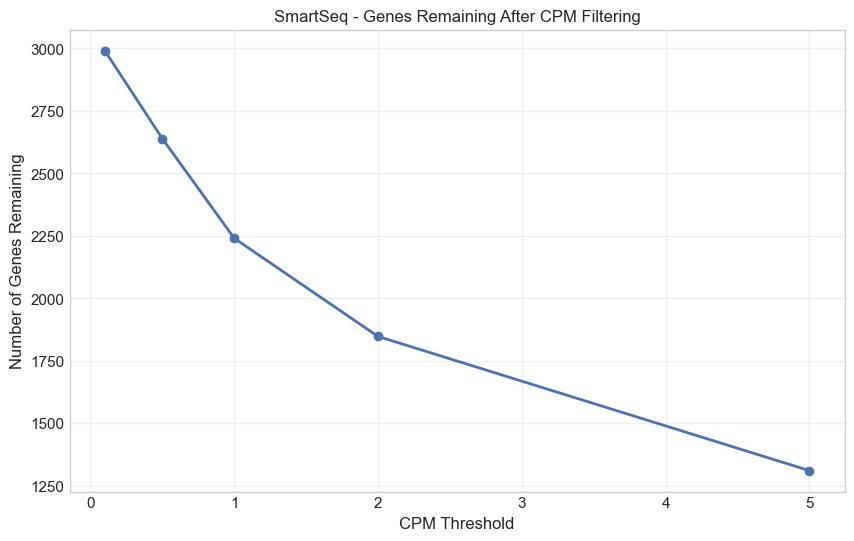

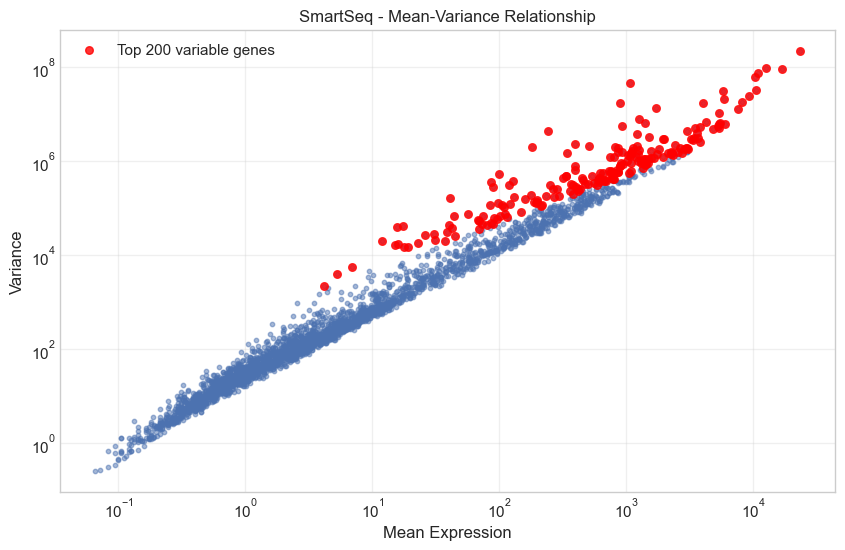

Intersection of significant and highly variable genes: 1901

DropSeq:
CPM threshold 0.1: 181 genes remain
CPM threshold 0.5: 45 genes remain
CPM threshold 1: 14 genes remain
CPM threshold 2: 3 genes remain
CPM threshold 5: 0 genes remain


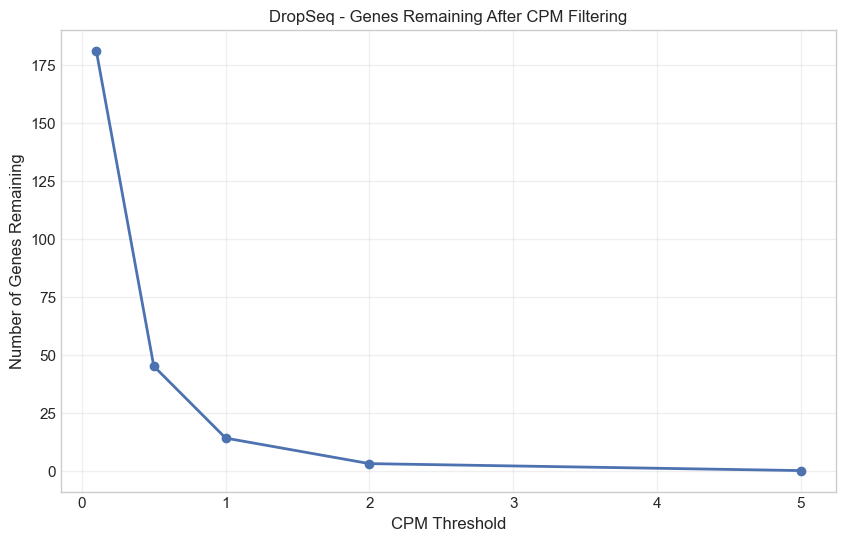

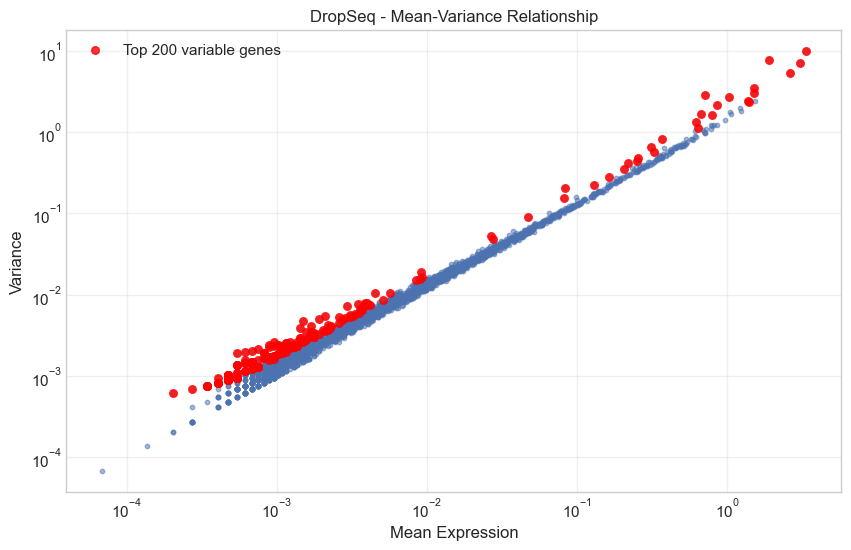

Intersection of significant and highly variable genes: 1732
SmartSeq - cpm_filtered subset shape: (182, 2241)
SmartSeq - highly_variable subset shape: (182, 2001)
SmartSeq - significant subset shape: (182, 1902)
DropSeq - cpm_filtered subset shape: (14682, 2497)
DropSeq - highly_variable subset shape: (14682, 2001)
DropSeq - significant subset shape: (14682, 1733)


In [16]:
from statsmodels.stats.multitest import multipletests

def select_features(data, dataset_name, threshold_final):

    print(f"\n{dataset_name}:")
    
    #Separate features and target
    X = data.drop('target', axis=1)
    y = data['target']
    
    #Method 1: Filter by Count Per Million (CPM)
    
    #Mean expression per gene
    mean_expr = X.mean()
    
    #Different CPM thresholds
    cpm_thresholds = [0.1, 0.5, 1, 2, 5]
    genes_kept = []
    
    for threshold in cpm_thresholds:
        #Keep genes with mean expression above threshold
        high_expr_genes = mean_expr[mean_expr > threshold].index.tolist()
        genes_kept.append(len(high_expr_genes))
        print(f"CPM threshold {threshold}: {len(high_expr_genes)} genes remain")
    
    #Plot genes remaining vs CPM threshold
    plt.figure(figsize=(10, 6))
    plt.plot(cpm_thresholds, genes_kept, marker='o', linestyle='-', linewidth=2)
    plt.xlabel('CPM Threshold')
    plt.ylabel('Number of Genes Remaining')
    plt.title(f"{dataset_name} - Genes Remaining After CPM Filtering")
    plt.grid(True, alpha=0.3)
    plt.savefig(f"plots/{dataset_name}_cpm_filtering.png")
    plt.show()
    
    #Check the values that were chosen below
    selected_by_cpm = mean_expr[mean_expr > threshold_final].index.tolist()
    
    #Method 2: Select highly variable genes
    #Similar to what Seurat does in R, but implemented in Python
    
    #Calculate mean and variance for each gene
    gene_stats = pd.DataFrame({
        'mean': X.mean(),
        'var': X.var()
    })
    
    #Calculate (dispersion)
    gene_stats['dispersion'] = gene_stats['var'] / gene_stats['mean']
    
    #Sort by dispersion
    gene_stats = gene_stats.sort_values('dispersion', ascending=False)
    
    #Select top 2000 highly variable genes
    top_hvgs = gene_stats.index[:2000].tolist()
    
    #Visualize mean-variance relationship
    plt.figure(figsize=(10, 6))
    plt.scatter(gene_stats['mean'], gene_stats['var'], alpha=0.5, s=10)
    plt.scatter(gene_stats.loc[top_hvgs[:200], 'mean'], 
               gene_stats.loc[top_hvgs[:200], 'var'], 
               alpha=0.8, s=30, color='red', label='Top 200 variable genes')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Mean Expression')
    plt.ylabel('Variance')
    plt.title(f"{dataset_name} - Mean-Variance Relationship")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f"plots/{dataset_name}_mean_variance.png")
    plt.show()
    
    intersect_genes = list(set(selected_by_cpm) & set(top_hvgs))
    print(f"Intersection of significant and highly variable genes: {len(intersect_genes)}")
    
    #Combine all selected feature sets
    selected_features = {
        'cpm_filtered': selected_by_cpm,
        'highly_variable': top_hvgs,
        'significant': intersect_genes
    }
    
    return selected_features

#Apply feature selection to both datasets
smartseq_features = select_features(smartseq_data, "SmartSeq", 1)
dropseq_features = select_features(dropseq_data, "DropSeq", 0.001)

#Create data subsets with selected features
def create_feature_subsets(data, selected_features, dataset_name):    
    subsets = {}
    
    #For each feature selection method
    for method, features in selected_features.items():
        if len(features) > 0:
            #Select columns and keep target
            subset = data[features + ['target']]
            subsets[method] = subset
            print(f"{dataset_name} - {method} subset shape: {subset.shape}")
    
    return subsets

#Create feature subsets for both datasets
smartseq_subsets = create_feature_subsets(smartseq_data, smartseq_features, "SmartSeq")
dropseq_subsets = create_feature_subsets(dropseq_data, dropseq_features, "DropSeq")

It is worth noting the output here that DropSeq has fewer genes surviving the intersection (1732 vs 1901 for SmartSeq) despite starting with the same number of total genes (3000). This suggests that DropSeq, being a droplet-based method, has more genes that are either lowly expressed or show less consistent variability patterns, possibly due to higher dropout rates or technical noise inherent in droplet-based single-cell sequencing. SmartSeq, being a plate-based method with typically higher sensitivity, retains more genes that are both well-expressed and highly variable, which aligns with the known technical differences between these sequencing platforms.

# 4. Create datasets for supervised learning


The code below prepares the data for the model training and evaluation by creating standardized train/test splits for each feature selection variant.

In [17]:
def prepare_supervised_datasets(data_dict, selected_features, dataset_name, original_data):

    print(f"\n{dataset_name}:")
    
    supervised_datasets = {}
    
    #Add original full dataset
    data_dict['full'] = original_data.copy()
    
    #For each dataset variant
    for name, df in data_dict.items():
        print(f"Processing {name} dataset")
        
        #Split features and target
        X = StandardScaler().fit_transform(df.drop('target', axis=1))
        y = df['target']
        
        #Create train/test split (80/20)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=24, stratify=y
        )
        
        #Store in dictionary
        supervised_datasets[name] = {
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test
        }
        
        print(f"  Train: {X_train.shape}, Test: {X_test.shape}")
    
    return supervised_datasets

#Prepare supervised datasets for SmartSeq
smartseq_supervised = prepare_supervised_datasets(
    smartseq_subsets, 
    smartseq_features, 
    "SmartSeq",
    original_data=smartseq_data
)

#Prepare supervised datasets for DropSeq
dropseq_supervised = prepare_supervised_datasets(
    dropseq_subsets, 
    dropseq_features, 
    "DropSeq",
    original_data=dropseq_data
)


SmartSeq:
Processing cpm_filtered dataset
  Train: (145, 2240), Test: (37, 2240)
Processing highly_variable dataset
  Train: (145, 2000), Test: (37, 2000)
Processing significant dataset
  Train: (145, 1901), Test: (37, 1901)
Processing full dataset
  Train: (145, 3000), Test: (37, 3000)

DropSeq:
Processing cpm_filtered dataset
  Train: (11745, 2496), Test: (2937, 2496)
Processing highly_variable dataset
  Train: (11745, 2000), Test: (2937, 2000)
Processing significant dataset
  Train: (11745, 1732), Test: (2937, 1732)
Processing full dataset
  Train: (11745, 3000), Test: (2937, 3000)


# 5. Supervised Learning - XGBoost

Here, we implement the XGBoost Classifier and perform hyperparameter optimization using RandomizedSearchCV (testing 25 parameter combinations across 6 key parameters including n_estimators, max_depth, and learning_rate), train models on the dataset variants (full and significant feature sets for both SmartSeq and DropSeq), evaluate performance using multiple metrics (accuracy, precision, recall, F1-score, AUC-ROC), and generate confusion matrices and ROC curves for visualization.
<br> <br>

Breakdown of the hyperparameters:

* n_estimators [50, 100, 200, 300]: The number of boosting trees to build - more trees can capture more complex patterns but risk overfitting and increase training time.
* max_depth [3, 4, 5, 6, 7]: Maximum depth each tree can grow - deeper trees capture more complex feature interactions but are prone to overfitting.
* learning_rate [0.01, 0.05, 0.1, 0.2]: Step size for each boosting iteration, controlling how much each tree contributes to the final prediction. Smaller values require more trees but provide better generalization, larger values converge faster but may overshoot optimal solutions.
* subsample [0.7, 0.8, 0.9, 1.0]: Fraction of training samples used for each tree - values less than 1.0 introduce randomness that prevents overfitting and speeds up training and values of 0.7-0.9 provides good balance between variance reduction and maintaining sufficient data per tree.
* colsample_bytree [0.7, 0.8, 0.9, 1.0]: Fraction of features randomly selected for each tree - reduces overfitting by preventing trees from always using the same dominant features
* gamma [0, 0.1, 0.2, 0.3]: Minimum loss reduction required to make a split - acts as regularization by pruning splits that don't significantly improve the model


SmartSeq:

Variant: full
Best parameters: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 1.0}
Best cross-validation score: 0.9862
Test accuracy: 1.0000
Test precision: 1.0000
Test recall: 1.0000
Test F1 score: 1.0000
Test AUC: 1.0000


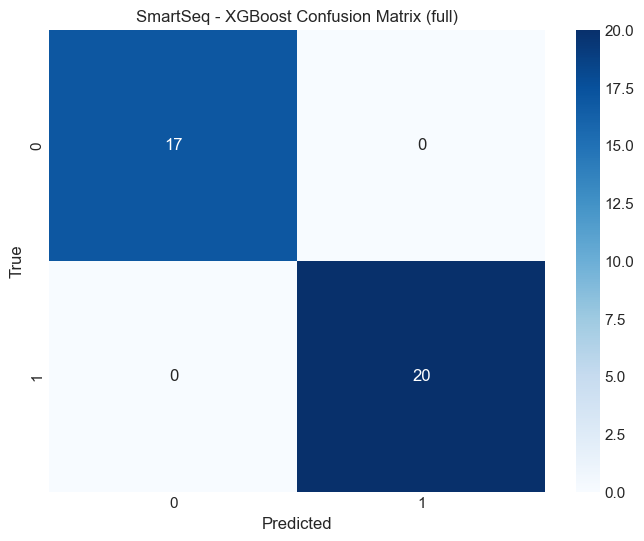

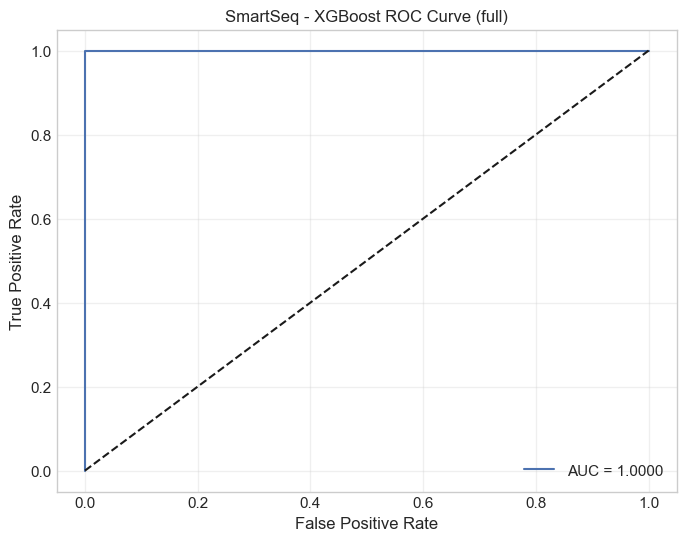

Model saved to models/SmartSeq_xgboost_full.pkl

Variant: significant
Best parameters: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 1.0}
Best cross-validation score: 0.9862
Test accuracy: 1.0000
Test precision: 1.0000
Test recall: 1.0000
Test F1 score: 1.0000
Test AUC: 1.0000


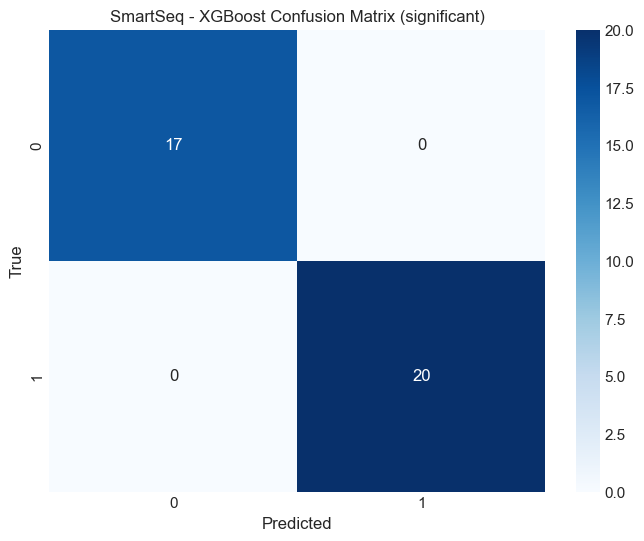

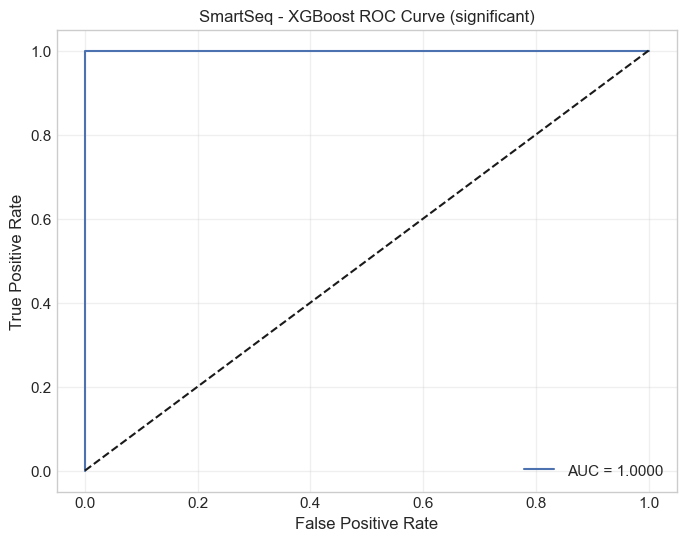

Model saved to models/SmartSeq_xgboost_significant.pkl

DropSeq:

Variant: significant
Best parameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 0.8}
Best cross-validation score: 0.9507
Test accuracy: 0.9527
Test precision: 0.9571
Test recall: 0.9652
Test F1 score: 0.9611
Test AUC: 0.9909


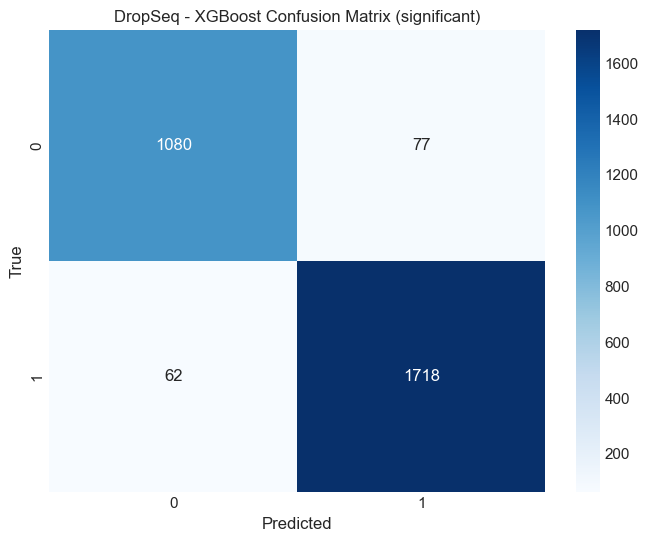

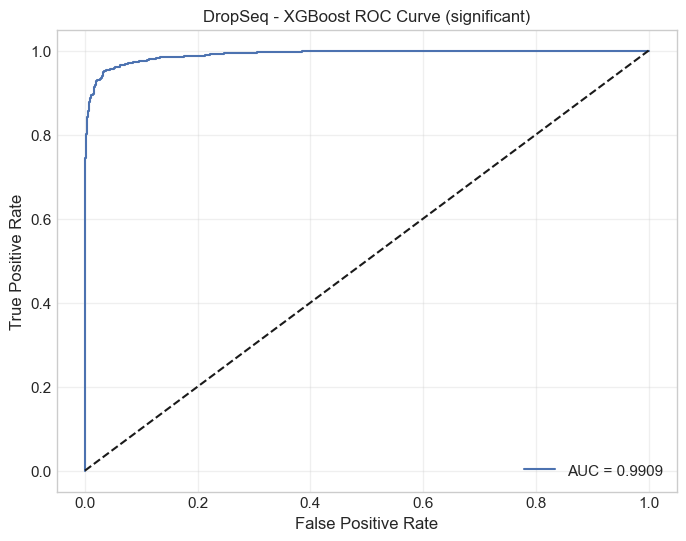

Model saved to models/DropSeq_xgboost_significant.pkl


In [19]:
#Train an XGBoost classifier and evaluate its performance

def train_xgboost(datasets, dataset_name):

    print(f"\n{dataset_name}:")

    xgb_results = {}

    #For each dataset variant
    for variant_name, data in datasets.items():
        print(f"\nVariant: {variant_name}")

        #Get training and testing data
        X_train = data['X_train']
        X_test = data['X_test']
        y_train = data['y_train']
        y_test = data['y_test']

        #Define parameter grid for RandomizedSearchCV
        param_grid = {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [3, 4, 5, 6, 7],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'subsample': [0.7, 0.8, 0.9, 1.0],
            'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
            'gamma': [0, 0.1, 0.2, 0.3]
        }

        #Initialize XGBoost classifier
        xgb_model = XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            use_label_encoder=False,
            random_state=22
        )

        #Use RandomizedSearchCV to find best parameters
        cv = RandomizedSearchCV(
            xgb_model, param_grid,
            cv=5, scoring='accuracy',
            n_iter=25, random_state=22, n_jobs=8
        )

        cv.fit(X_train, y_train)

        print(f"Best parameters: {cv.best_params_}")
        print(f"Best cross-validation score: {cv.best_score_:.4f}")

        #Get best model
        best_model = cv.best_estimator_

        #Evaluate on test set
        y_pred = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]

        #Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        #Calculate AUC if possible
        try:
            auc = roc_auc_score(y_test, y_pred_proba)
        except:
            auc = None

        print(f"Test accuracy: {accuracy:.4f}")
        print(f"Test precision: {precision:.4f}")
        print(f"Test recall: {recall:.4f}")
        print(f"Test F1 score: {f1:.4f}")
        if auc:
            print(f"Test AUC: {auc:.4f}")

        #Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"{dataset_name} - XGBoost Confusion Matrix ({variant_name})")
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(f"plots/{dataset_name}_xgboost_{variant_name}_cm.png")
        plt.show()

        #Plot ROC curve if possible
        if auc:
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f"{dataset_name} - XGBoost ROC Curve ({variant_name})")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.savefig(f"plots/{dataset_name}_xgboost_{variant_name}_roc.png")
            plt.show()
            
        #Save model
        model_path = f"models/{dataset_name}_xgboost_{variant_name}.pkl"
        joblib.dump(best_model, model_path)
        print(f"Model saved to {model_path}")

        #Store results
        xgb_results[variant_name] = {
            'model': best_model,
            'best_params': cv.best_params_,
            'cv_score': cv.best_score_,
            'test_accuracy': accuracy,
            'test_precision': precision,
            'test_recall': recall,
            'test_f1': f1,
            'test_auc': auc,
            'confusion_matrix': cm
        }

    return xgb_results

#Train XGBoost on SmartSeq datasets variants
smartseq_variants = {
    k: smartseq_supervised[k]
    # for k in ['full', 'significant'] #add these if you want but my laptop crashes when I run them
    for k in ['full', "significant"]
}

smartseq_xgb = train_xgboost(smartseq_variants, "SmartSeq")

#Train XGBoost on DropSeq datasets variants
dropseq_variants = {
    k: dropseq_supervised[k]
    # for k in ['full', 'significant'] #add these if you want but my laptop crashes when I run them
    for k in ["significant"]
}

dropseq_xgb = train_xgboost(dropseq_variants, "DropSeq")

# 6. Supervised Learning - (UMAP + K-Nearest Neighbors) pipeline


Here, we implement the K-Nearest Neighbors (KNN) Classifier integrated with UMAP (Uniform Manifold Approximation and Projection) dimensionality reduction in a scikit-learn pipeline. The pipeline first applies UMAP to transform high-dimensional gene expression data into a lower-dimensional space that preserves local neighborhood structure, making it more suitable for distance-based KNN classification. We perform comprehensive hyperparameter optimization using RandomizedSearchCV with 5-fold cross-validation, testing 25 parameter combinations across 7 key parameters that control both the UMAP preprocessing stage (n_neighbors, n_components, min_dist, metric) and KNN classification stage (n_neighbors, weights, metric). Models are trained on multiple dataset variants including full and significant feature sets for both SmartSeq and DropSeq protocols, with performance evaluated using multiple classification metrics (accuracy, precision, recall, F1-score, AUC-ROC) and results visualized through confusion matrices and ROC curves to assess model effectiveness across different data preprocessing approaches.
<br> <br>

Breakdown of the hyperparameters:

1. UMAP Parameters:
* umap__n_neighbors [5, 10, 15, 20, 30]: Number of neighboring points used in local approximations of manifold structure - smaller values focus on local structure while larger values preserve more global structure, with 5-15 typically good for local patterns and 20-30 for global relationships.
* umap__n_components [2, 5, 10, 100]: Target dimensionality for the reduced space - fewer components create more aggressive compression but may lose important information, while more components preserve detail but may include noise.
* umap__min_dist [0.1, 0.3, 0.5]: Minimum distance between points in the low-dimensional representation - smaller values allow points to be packed tightly together (preserving local structure), while larger values ensure points are more spread out (better for visualization).
* umap__metric ['manhattan', 'correlation', 'cosine']: Distance metric used to measure similarity between high-dimensional points - Manhattan distance works well for sparse data, correlation captures linear relationships, and cosine distance is effective for high-dimensional data where magnitude matters less than direction.

2. KNN Parameters:
* knn__n_neighbors [3, 5, 7, 9, 11, 15, 20]: Number of nearest neighbors to consider for classification - smaller values create more complex decision boundaries that may overfit, while larger values create smoother boundaries but may underfit by including irrelevant neighbors.
* knn__weights ['uniform', 'distance']: Weighting scheme for neighbor contributions - uniform gives equal weight to all neighbors within the k-neighborhood, while distance weighting gives more influence to closer neighbors and less to farther ones.
* knn__metric ['cosine', 'manhattan']: Distance metric for finding nearest neighbors in the reduced UMAP space - cosine distance measures angular similarity (good for normalized data), while Manhattan distance uses absolute differences along each dimension (robust to outliers).


SmartSeq:

Variant: full
Best parameters: {'umap__n_neighbors': 30, 'umap__n_components': 2, 'umap__min_dist': 0.1, 'umap__metric': 'correlation', 'knn__weights': 'uniform', 'knn__n_neighbors': 9, 'knn__metric': 'cosine'}
Best cross-validation score: 0.9517
Test accuracy: 0.9730
Test precision: 1.0000
Test recall: 0.9500
Test F1 score: 0.9744
Test AUC: 0.9750


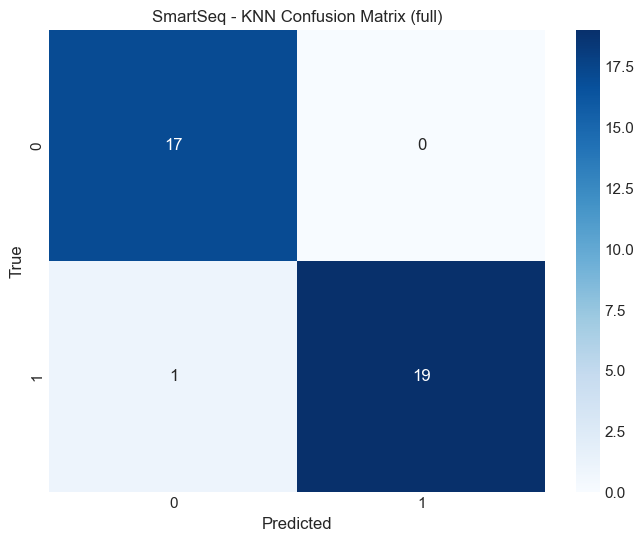

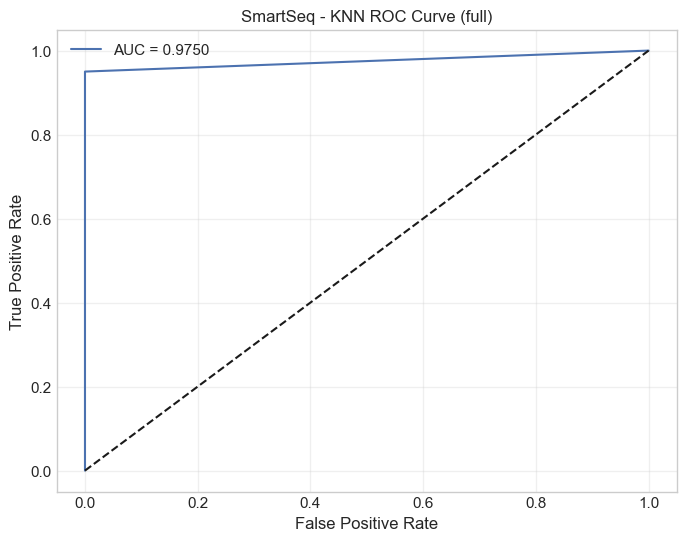

Model saved to models/SmartSeq_knn_full.pkl

Variant: significant
Best parameters: {'umap__n_neighbors': 20, 'umap__n_components': 100, 'umap__min_dist': 0.3, 'umap__metric': 'cosine', 'knn__weights': 'distance', 'knn__n_neighbors': 11, 'knn__metric': 'manhattan'}
Best cross-validation score: 0.9517
Test accuracy: 0.9730
Test precision: 1.0000
Test recall: 0.9500
Test F1 score: 0.9744
Test AUC: 0.9750


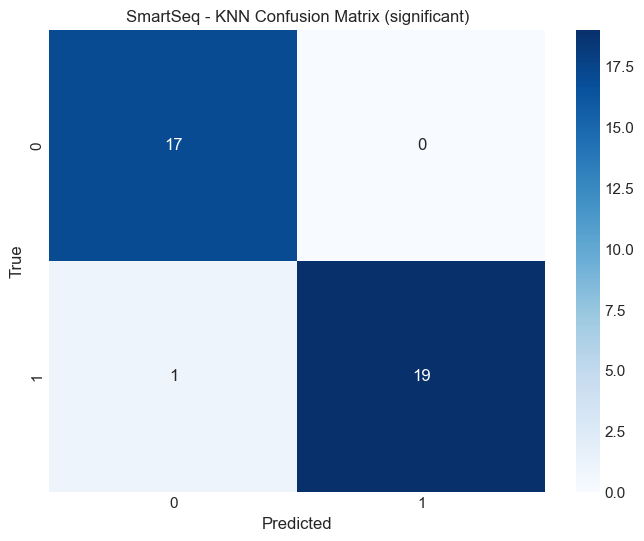

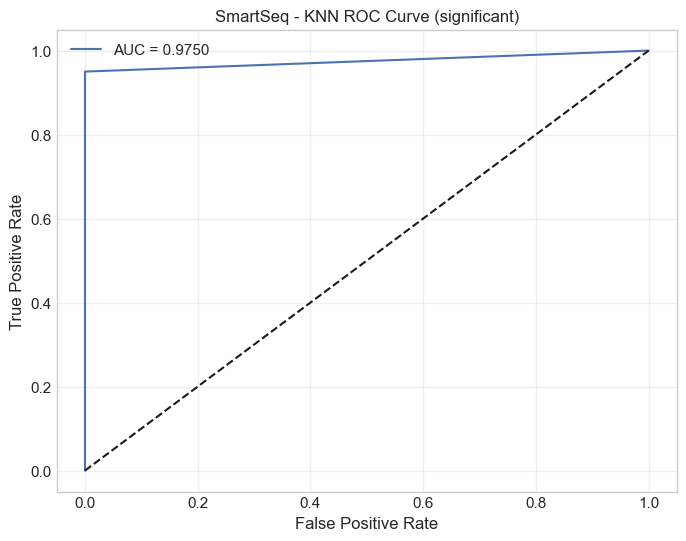

Model saved to models/SmartSeq_knn_significant.pkl

DropSeq:

Variant: significant
Best parameters: {'umap__n_neighbors': 5, 'umap__n_components': 5, 'umap__min_dist': 0.3, 'umap__metric': 'cosine', 'knn__weights': 'distance', 'knn__n_neighbors': 11, 'knn__metric': 'cosine'}
Best cross-validation score: 0.7181
Test accuracy: 0.7194
Test precision: 0.7987
Test recall: 0.7180
Test F1 score: 0.7562
Test AUC: 0.7284


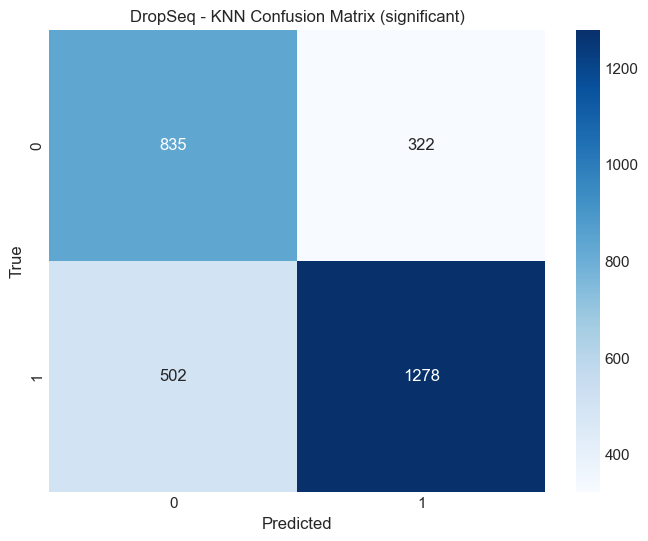

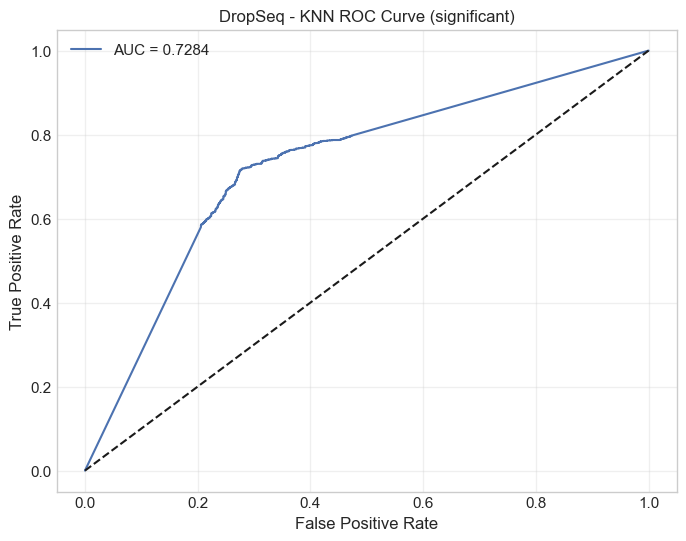

Model saved to models/DropSeq_knn_significant.pkl


In [20]:
#Train a KNN classifier and evaluate its performance

def train_knn(datasets, dataset_name):

    print(f"\n{dataset_name}:")
    
    knn_results = {}
    
    #For each dataset variant
    for variant_name, data in datasets.items():
        print(f"\nVariant: {variant_name}")
        
        #Get training and testing data
        X_train = data['X_train']
        X_test = data['X_test']
        y_train = data['y_train']
        y_test = data['y_test']
        
        #Define parameter grid for GridSearchCV
        param_grid = {
            'umap__n_neighbors': [5, 10, 15, 20, 30],
            'umap__n_components': [ 2, 5, 10, 100],
            'umap__min_dist': [ 0.1, 0.3, 0.5],
            'umap__metric': ['manhattan', 'correlation', 'cosine'],
            'knn__n_neighbors': [3, 5, 7, 9, 11, 15, 20],
            'knn__weights': ['uniform', 'distance'],
            'knn__metric': ['cosine', 'manhattan']
        }
        
        pipe = Pipeline([
        ('umap', umap.UMAP(random_state=51)),
        ('knn', KNeighborsClassifier())  ])

        #Use GridSearchCV to find best parameters
        cv = RandomizedSearchCV(
            pipe, param_grid, 
            cv=5, scoring='accuracy',
            n_iter=25,
            random_state=21,
            n_jobs=8
        )
        
        cv.fit(X_train, y_train)
        
        print(f"Best parameters: {cv.best_params_}")
        print(f"Best cross-validation score: {cv.best_score_:.4f}")
        
        #Get best model
        best_model = cv.best_estimator_
        
        #Evaluate on test set
        y_pred = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        
        #Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        
        print(f"Test accuracy: {accuracy:.4f}")
        print(f"Test precision: {precision:.4f}")
        print(f"Test recall: {recall:.4f}")
        print(f"Test F1 score: {f1:.4f}")
        print(f"Test AUC: {auc:.4f}")
        
        #Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"{dataset_name} - KNN Confusion Matrix ({variant_name})")
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(f"plots/{dataset_name}_knn_{variant_name}_cm.png")
        plt.show()
        
        #Plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f"{dataset_name} - KNN ROC Curve ({variant_name})")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(f"plots/{dataset_name}_umap_knn_{variant_name}_roc.png")
        plt.show()
        
        #Save model
        model_path = f"models/{dataset_name}_knn_{variant_name}.pkl"
        joblib.dump(best_model, model_path)
        print(f"Model saved to {model_path}")
        
        #Store results
        knn_results[variant_name] = {
            'model': best_model,
            'best_params': cv.best_params_,
            'cv_score': cv.best_score_,
            'test_accuracy': accuracy,
            'test_precision': precision,
            'test_recall': recall,
            'test_f1': f1,
            'test_auc': auc,
            'confusion_matrix': cm
        }
    
    return knn_results

#Train KNN on SmartSeq datasets
smartseq_knn_variants = {
    k: smartseq_supervised[k] 
    for k in ['full', 'significant']
}

smartseq_knn = train_knn(smartseq_knn_variants, "SmartSeq")

#Train KNN on DropSeq datasets
dropseq_knn_variants = {
    k: dropseq_supervised[k] 
    for k in [ 'significant']
}

dropseq_knn = train_knn(dropseq_knn_variants, "DropSeq")

# 7. Supervised Learning - Random Forest


Here, we implement the Random Forest Classifier with comprehensive model analysis including validation curves and learning curves, perform hyperparameter optimization using RandomizedSearchCV (testing 25 parameter combinations across 7 key parameters after determining optimal n_estimators through validation curve analysis), train models on the dataset variants (full and significant feature sets for both SmartSeq and DropSeq), evaluate performance using multiple metrics (accuracy, precision, recall, F1-score, AUC-ROC), and generate confusion matrices, ROC curves, validation curves, and learning curves for thorough model evaluation.
<br> <br>

Breakdown of the hyperparameters:

1. *Tree Structure Parameters:*
* n_estimators [determined via validation curve]: Number of decision trees in the forest - more trees generally improve performance and reduce overfitting through ensemble averaging, but increase computational cost. The optimal value is determined through validation curve analysis testing values from 10 to 300.
* max_depth [None, 10, 20, 30, 40]: Maximum depth each tree can grow - None allows trees to expand until leaves are pure or contain minimum samples, while specific limits (10-40) prevent overfitting by constraining tree complexity and reducing variance.
* min_samples_split [2, 5, 10]: Minimum number of samples required to split an internal node - higher values prevent overfitting by requiring more evidence before creating splits, with 2 allowing maximum flexibility and 10 providing strong regularization.
* min_samples_leaf [1, 2, 4]: Minimum number of samples required in each leaf node - acts as regularization by ensuring leaves represent meaningful patterns rather than noise, with higher values creating smoother decision boundaries.

2. *Feature Selection Parameters:*
* max_features ['sqrt', 'log2', None]: Number of features considered for each split - 'sqrt' uses square root of total features (good balance for classification), 'log2' uses logarithm base 2 (more conservative), and None considers all features (may lead to overfitting but captures all information).

3. *Sampling Parameters:*
* bootstrap [True, False]: Whether to use bootstrap sampling when building trees - True enables bagging (sampling with replacement) which increases diversity between trees and reduces overfitting, while False uses the entire dataset for each tree.

4. *Class Handling Parameters:*
* class_weight [None, 'balanced', 'balanced_subsample']: Strategy for handling class imbalance - None treats all classes equally, 'balanced' adjusts weights inversely proportional to class frequencies, and 'balanced_subsample' adjusts weights based on bootstrap sample composition.


SmartSeq:

Variant: full
Optimal n_estimators: 10


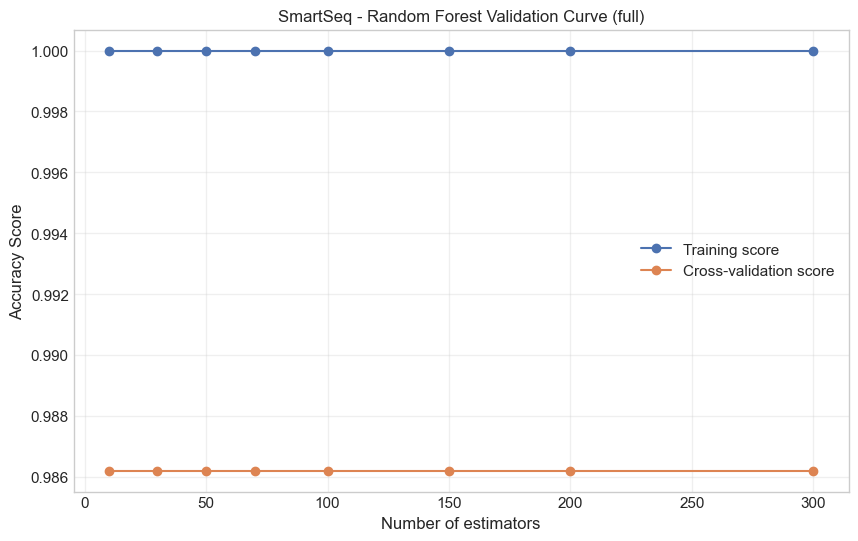

Best parameters: {'n_estimators': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'class_weight': 'balanced_subsample', 'bootstrap': True}
Best cross-validation score: 0.9724


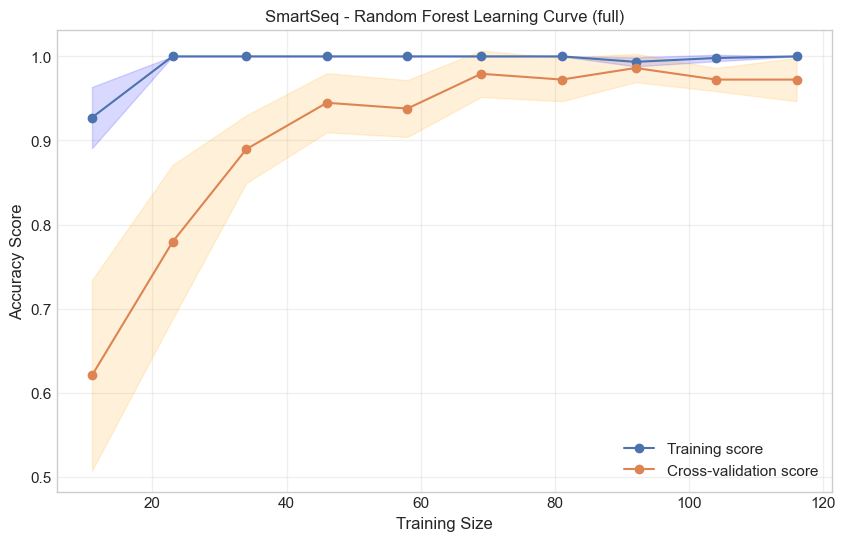

Test accuracy: 1.0000
Test precision: 1.0000
Test recall: 1.0000
Test F1 score: 1.0000
Test AUC: 1.0000


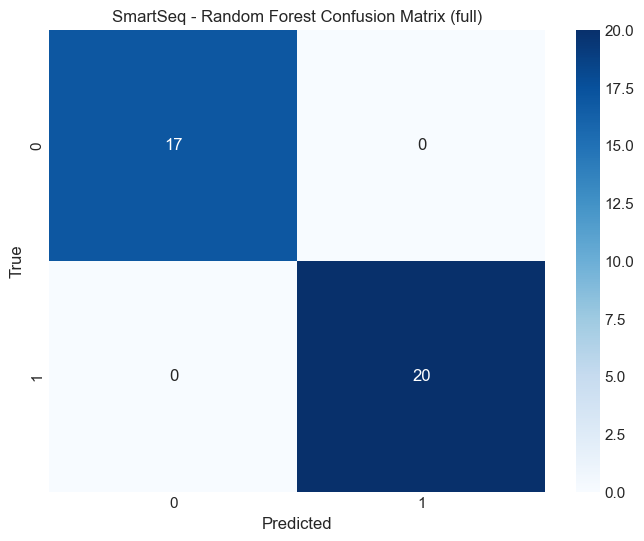

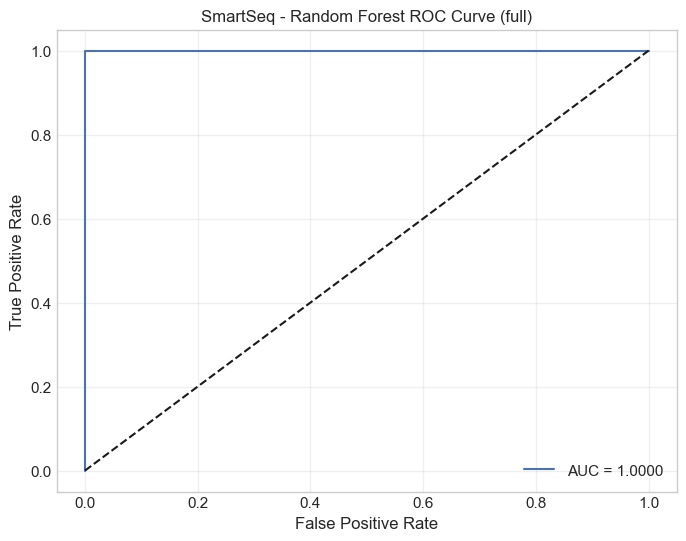

Model saved to models/SmartSeq_rf_full.pkl

Variant: significant
Optimal n_estimators: 200


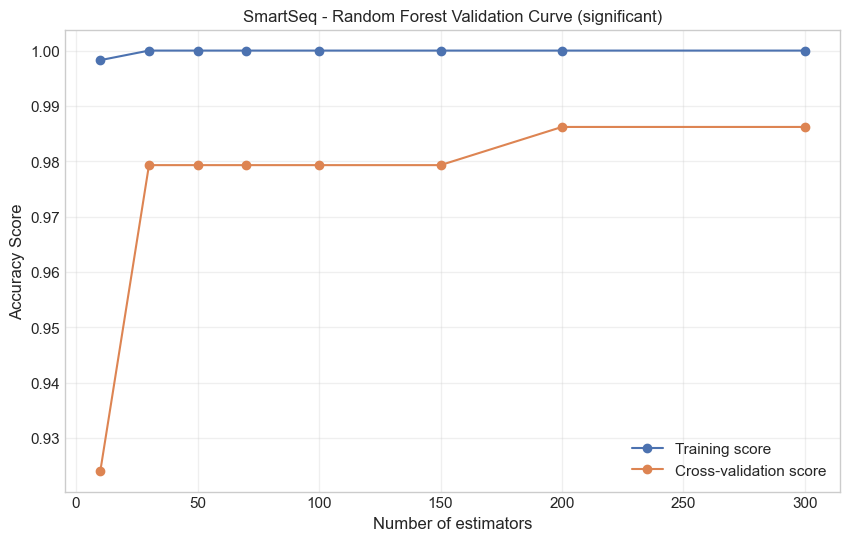

Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'class_weight': None, 'bootstrap': True}
Best cross-validation score: 0.9862


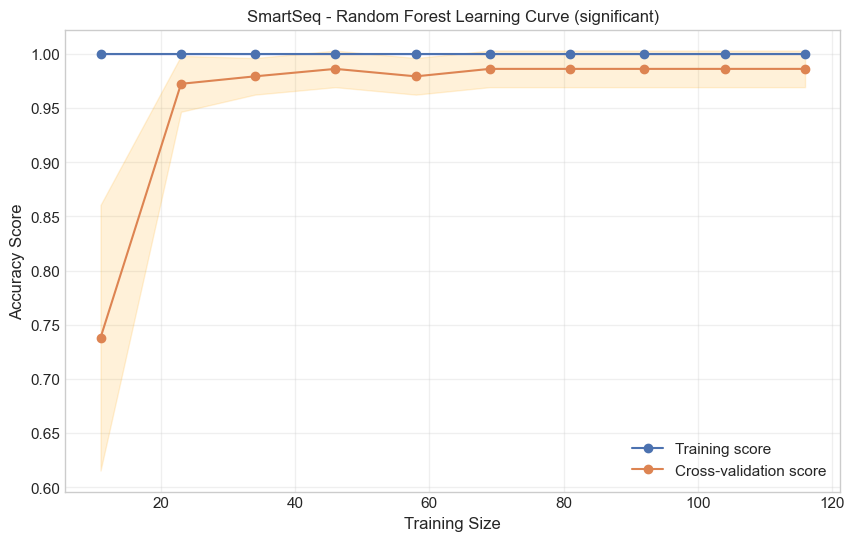

Test accuracy: 1.0000
Test precision: 1.0000
Test recall: 1.0000
Test F1 score: 1.0000
Test AUC: 1.0000


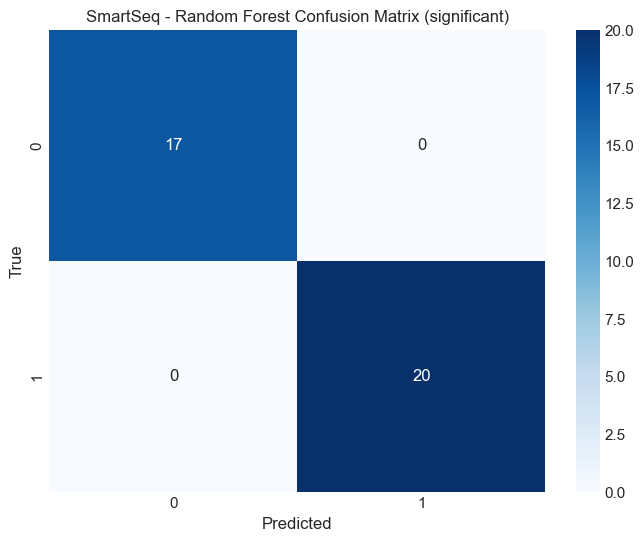

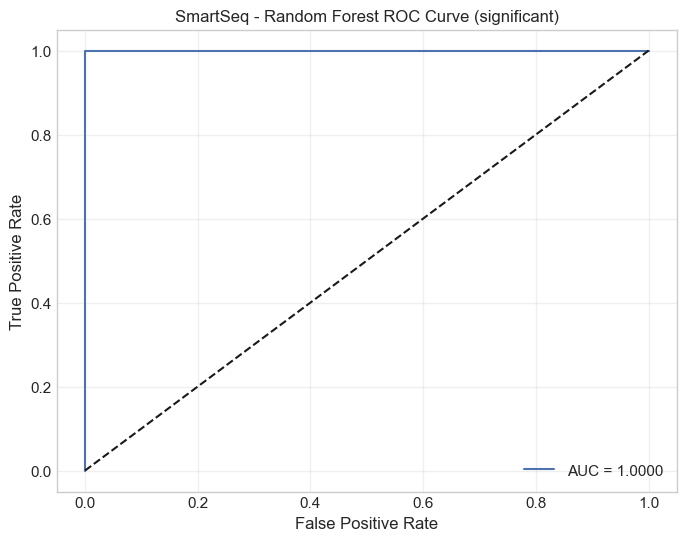

Model saved to models/SmartSeq_rf_significant.pkl

DropSeq:

Variant: significant
Optimal n_estimators: 200


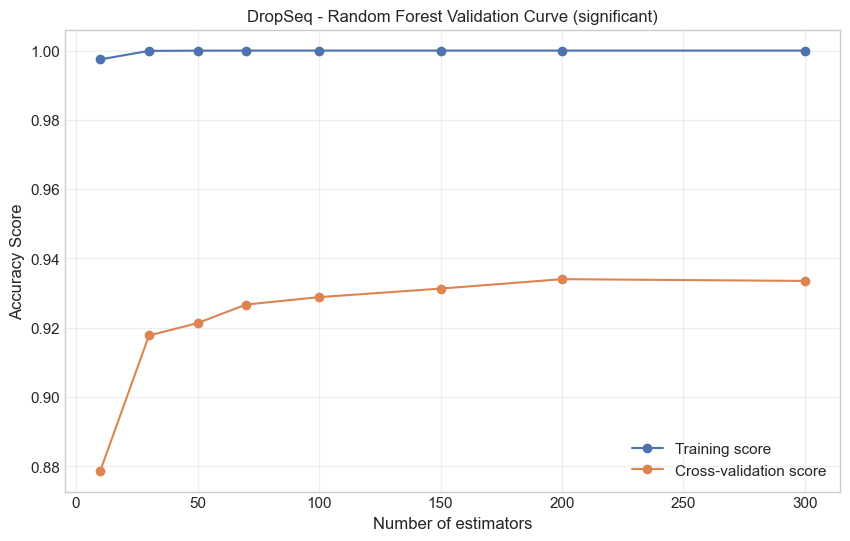

Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20, 'class_weight': 'balanced_subsample', 'bootstrap': False}
Best cross-validation score: 0.9473


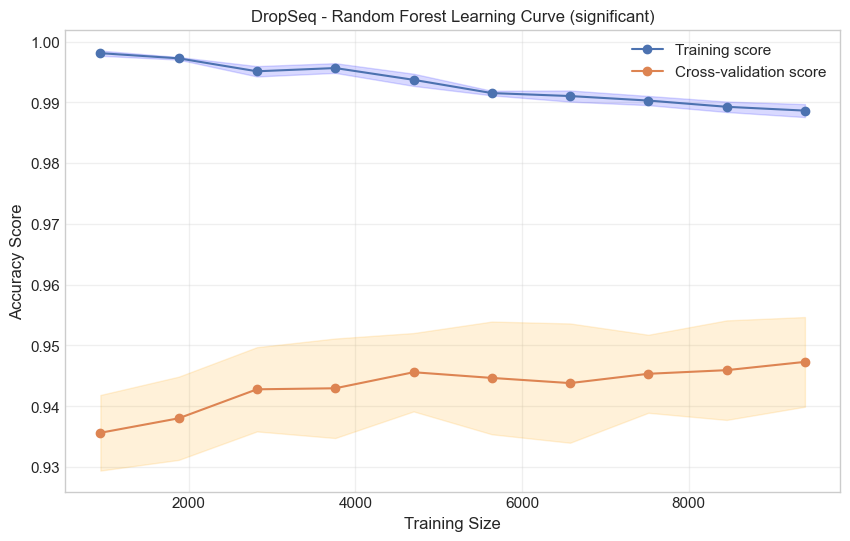

Test accuracy: 0.9503
Test precision: 0.9595
Test recall: 0.9584
Test F1 score: 0.9590
Test AUC: 0.9883


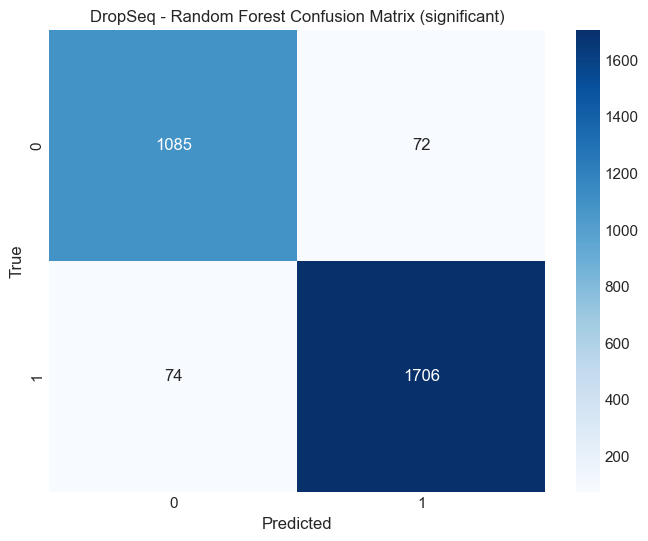

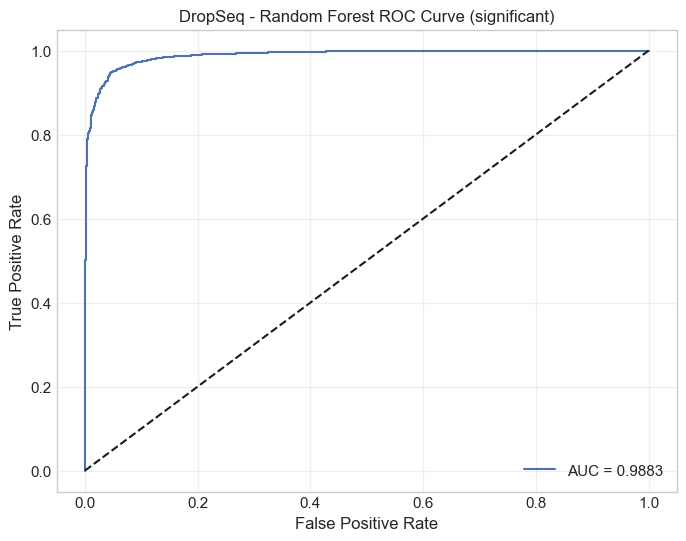

Model saved to models/DropSeq_rf_significant.pkl


In [21]:
#Train a Random Forest classifier and evaluate its performance

def train_random_forest(datasets, dataset_name):

    print(f"\n{dataset_name}:")
    
    rf_results = {}
    
    #For each dataset variant
    for variant_name, data in datasets.items():
        print(f"\nVariant: {variant_name}")
        
        #Get training and testing data
        X_train = data['X_train']
        X_test = data['X_test']
        y_train = data['y_train']
        y_test = data['y_test']
        
        #Instead of using the ValidationCurve visualizer, directly use validation_curve from sklearn
        param_range = [10, 30, 50, 70, 100, 150, 200, 300]
        
        from sklearn.model_selection import validation_curve
        train_scores, test_scores = validation_curve(
            RandomForestClassifier(random_state=2),
            X_train, y_train,
            param_name="n_estimators",
            param_range=param_range,
            cv=5,
            scoring='accuracy',
            n_jobs=8
        )
        
        #Calculate mean test scores to find optimal n_estimators
        mean_test_scores = np.mean(test_scores, axis=1)
        optimal_idx = np.argmax(mean_test_scores)
        optimal_n_estimators = param_range[optimal_idx]
        print(f"Optimal n_estimators: {optimal_n_estimators}")
        
        #Plot validation curve manually
        plt.figure(figsize=(10, 6))
        plt.plot(param_range, np.mean(train_scores, axis=1), marker='o', label='Training score')
        plt.plot(param_range, mean_test_scores, marker='o', label='Cross-validation score')
        plt.title(f"{dataset_name} - Random Forest Validation Curve ({variant_name})")
        plt.xlabel('Number of estimators')
        plt.ylabel('Accuracy Score')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.savefig(f"plots/{dataset_name}_rf_{variant_name}_validation_curve.png")
        plt.show()
        
        #Define parameter grid for GridSearchCV with optimal n_estimators
        param_grid = {
            'n_estimators': [optimal_n_estimators],
            'max_depth': [None, 10, 20, 30, 40],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None],
            'bootstrap': [True, False],
            'class_weight': [None, 'balanced', 'balanced_subsample']
        }
        
        #Initialize Random Forest classifier
        rf_model = RandomForestClassifier(random_state=11)
        
        #Took too long
        # cv = GridSearchCV(
        #     rf_model, param_grid, 
        #     cv=2, scoring='accuracy',
        #     n_jobs=8
        # )

        cv = RandomizedSearchCV(
            rf_model, param_grid,
            cv=5, scoring='accuracy',
            n_iter=25, random_state=22, n_jobs=8
        )
        cv.fit(X_train, y_train)
        
        print(f"Best parameters: {cv.best_params_}")
        print(f"Best cross-validation score: {cv.best_score_:.4f}")
        
        #Get best model
        best_model = cv.best_estimator_
        
        #Generate learning curves to understand model's learning behavior
        train_sizes = np.linspace(0.1, 1.0, 10)
        train_sizes, train_scores, test_scores = learning_curve(
            best_model, X_train, y_train, 
            train_sizes=train_sizes, cv=5, 
            scoring='accuracy', n_jobs=8
        )
        
        #Mean and std for training and test scores
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)
        
        #Plot learning curve
        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, train_mean, label='Training score', marker='o')
        plt.fill_between(
            train_sizes, train_mean - train_std, train_mean + train_std, 
            alpha=0.15, color='blue'
        )
        plt.plot(train_sizes, test_mean, label='Cross-validation score', marker='o')
        plt.fill_between(
            train_sizes, test_mean - test_std, test_mean + test_std, 
            alpha=0.15, color='orange'
        )
        plt.title(f"{dataset_name} - Random Forest Learning Curve ({variant_name})")
        plt.xlabel('Training Size')
        plt.ylabel('Accuracy Score')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.savefig(f"plots/{dataset_name}_rf_{variant_name}_learning_curve.png")
        plt.show()
        
        #Evaluate on test set
        y_pred = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        
        #Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        
        print(f"Test accuracy: {accuracy:.4f}")
        print(f"Test precision: {precision:.4f}")
        print(f"Test recall: {recall:.4f}")
        print(f"Test F1 score: {f1:.4f}")
        print(f"Test AUC: {auc:.4f}")
        
        #Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"{dataset_name} - Random Forest Confusion Matrix ({variant_name})")
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(f"plots/{dataset_name}_rf_{variant_name}_cm.png")
        plt.show()
        
        #Plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f"{dataset_name} - Random Forest ROC Curve ({variant_name})")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(f"plots/{dataset_name}_rf_{variant_name}_roc.png")
        plt.show()
        
        #Save model
        model_path = f"models/{dataset_name}_rf_{variant_name}.pkl"
        joblib.dump(best_model, model_path)
        print(f"Model saved to {model_path}")
        
        #Store results
        rf_results[variant_name] = {
            'model': best_model,
            'best_params': cv.best_params_,
            'cv_score': cv.best_score_,
            'test_accuracy': accuracy,
            'test_precision': precision,
            'test_recall': recall,
            'test_f1': f1,
            'test_auc': auc,
            'confusion_matrix': cm
        }
    
    return rf_results

#Train Random Forest on SmartSeq 
smartseq_rf_variants = {
    k: smartseq_supervised[k] 
    # for k in ['significant'] #add these if you want but my laptop crashes when I run them
    for k in ["full", 'significant']
}

smartseq_rf = train_random_forest(smartseq_rf_variants, "SmartSeq")

#Train Random Forest on DropSeq 
dropseq_rf_variants = {
    k: dropseq_supervised[k] 
    # for k in ['significant'] #add these if you want but my laptop crashes when I run them
    for k in ['significant']
}

dropseq_rf = train_random_forest(dropseq_rf_variants, "DropSeq")

# 8. Supervised Learning - SVM 


Here we train the SVM clasifier. We also tried running the classifier on the UMAP data,however we got worst results for the dropseq dataset , most likely because the dataset is more complex and therefore needs more information to be correctly classified.

We use `RandomizedSearchCV` to tune SVM hyperparameters efficiently. `C` is tested from 0.001 to 1000 on a log scale. Both `linear` and `rbf` kernels are included: linear is fast and works fine on simpler datasets like SmartSeq, while RBF can help in handling more complex structures like in DropSeq.For `gamma`, we use `scale`, `auto`, and values from 0.001 to 1000 spaced on a log scale. This helps the model test how much each point should influence the decision , lower values make it more general, higher values make it focus in more tightly.


SmartSeq:

Variant training: full
Best parameters: {'kernel': 'linear', 'gamma': np.float64(1.0), 'class_weight': None, 'C': np.float64(1000.0)}
Best cross-validation score: 0.9724
Test accuracy: 1.0000
Test precision: 1.0000
Test recall: 1.0000
Test F1 score: 1.0000


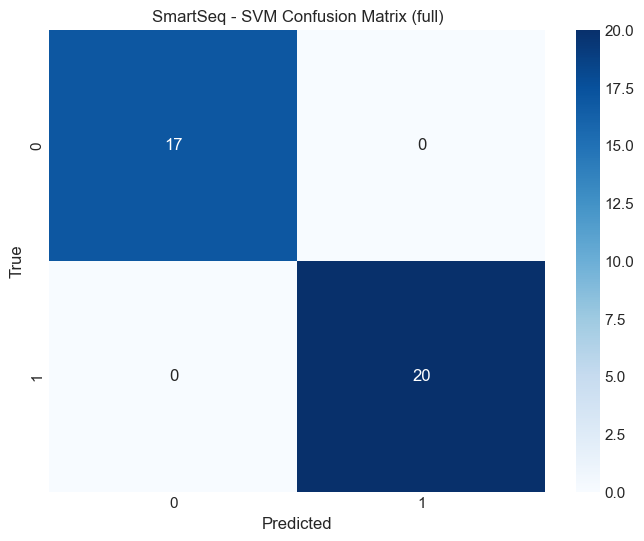

Model saved to models/SmartSeq_only_SVM_full.pkl

Variant training: significant
Best parameters: {'kernel': 'linear', 'gamma': np.float64(1.0), 'class_weight': None, 'C': np.float64(1000.0)}
Best cross-validation score: 0.9724
Test accuracy: 1.0000
Test precision: 1.0000
Test recall: 1.0000
Test F1 score: 1.0000


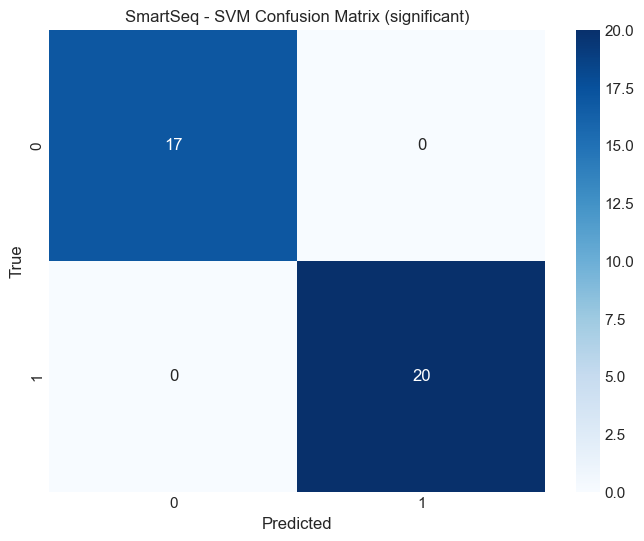

Model saved to models/SmartSeq_only_SVM_significant.pkl

DropSeq:

Variant training: significant
Best parameters: {'kernel': 'linear', 'gamma': np.float64(1.0), 'class_weight': None, 'C': np.float64(0.001)}
Best cross-validation score: 0.9341
Test accuracy: 0.9299
Test precision: 0.9477
Test recall: 0.9360
Test F1 score: 0.9418


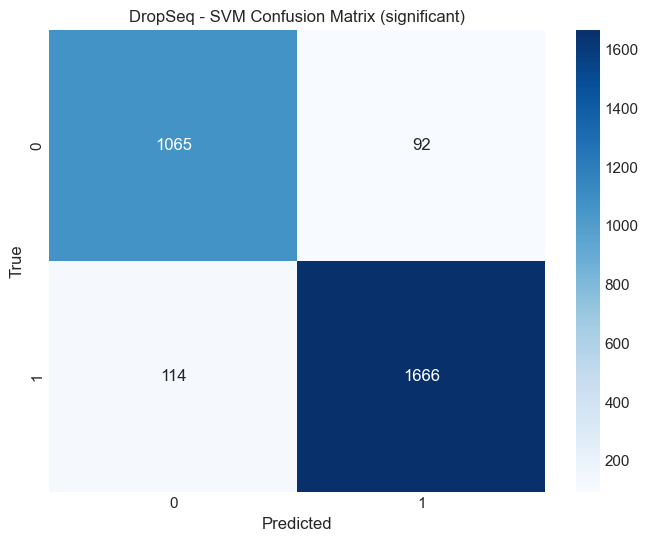

Model saved to models/DropSeq_only_SVM_significant.pkl


In [22]:
#Train an SVM classifier and evaluate its performance

def train_svm(datasets, dataset_name):

    print(f"\n{dataset_name}:")
    
    svm_results = {}
    
    #For each dataset variant
    for variant_name, data in datasets.items():
        print(f"\nVariant training: {variant_name}")
        
        #Get training and testing data
        X_train = data['X_train']
        X_test = data['X_test']
        y_train = data['y_train']
        y_test = data['y_test']
        
        #Define parameter grid for RandomizedSearchCV
        param_grid = {
            'C': np.logspace(-3, 3, 7),
            # 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], #takes a lot of time bcs the two other kernels are very computationally intensive
            'kernel': ['linear', 'rbf'],
            # 'degree': [2, 3, 4],  #For poly kernel
            'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)),
            'class_weight': [None, 'balanced']
        }
        
        #Initialize SVM classifier
        svm_model = SVC( random_state=1)
        
        #Use RandomizedSearchCV to find best parameters
        cv = RandomizedSearchCV(
            svm_model, param_grid, 
            cv=5, scoring='accuracy', 
            n_iter=20, random_state=2, n_jobs=8, 
        )
        
        cv.fit(X_train, y_train)
        
        print(f"Best parameters: {cv.best_params_}")
        print(f"Best cross-validation score: {cv.best_score_:.4f}")
        
        #Get best model
        best_model = cv.best_estimator_
        
        #Evaluate on test set
        y_pred = best_model.predict(X_test)
        #y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        
        #Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        #auc = roc_auc_score(y_test, y_pred_proba)
        
        print(f"Test accuracy: {accuracy:.4f}")
        print(f"Test precision: {precision:.4f}")
        print(f"Test recall: {recall:.4f}")
        print(f"Test F1 score: {f1:.4f}")
        #print(f"Test AUC: {auc:.4f}")
        
        #Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"{dataset_name} - SVM Confusion Matrix ({variant_name})")
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(f"plots/{dataset_name}_svm_{variant_name}_cm.png")
        plt.show()
        
        #Save model
        model_path = f"models/{dataset_name}_only_SVM_{variant_name}.pkl"
        joblib.dump(best_model, model_path)
        print(f"Model saved to {model_path}")

        #Store results
        svm_results[variant_name] = {
            'model': best_model,
            'best_params': cv.best_params_,
            'cv_score': cv.best_score_,
            'test_accuracy': accuracy,
            'test_precision': precision,
            'test_recall': recall,
            'test_f1': f1,
            # 'test_auc': auc,
            'confusion_matrix': cm
        }
    
    return svm_results

#Train SVM on SmartSeq 
#For SVM, dimensionality reduced data works better due to computational complexity
smartseq_svm_variants = {
    k: smartseq_supervised[k] 
    for k in ['full', "significant"]
}

smartseq_svm = train_svm(smartseq_svm_variants, "SmartSeq")

#Train SVM on DropSeq
dropseq_svm_variants = {
    k: dropseq_supervised[k] 
    for k in ["significant"]
}

dropseq_svm = train_svm(dropseq_svm_variants, "DropSeq")

# 9. Supervised Learning - MLP

Here the MLP is trained. Initially, we wanted to use a deep neural network using PyTorch however we stuck to the scikit-learn MLP as to not overfit.
<br> <br>We use `RandomizedSearchCV` to tune the MLP. Hidden layer sizes range from shallow (e.g., 50) to deeper setups like two layers of 200 ,which should be enough to test model capacity without overfitting. We use   `'relu'`, `'tanh'`, and `'logistic'` , which give a mix of fast and non-linear activations. We test the `'adam'`, `'sgd'`, and `'lbfgs'` solvers since we are solving a classificaiton problem. We sample `alpha`  with a log-uniform distribution from $1 \times 10^{-5}$  to 1 to control overfitting.


Dataset: SmartSeq
\Variant: full
Best parameters: {'activation': 'relu', 'alpha': np.float64(0.6155004178017708), 'batch_size': 50, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'adam'}
Best cross-validation score: 0.9658
Test accuracy: 1.0000
Test precision: 1.0000
Test recall: 1.0000
Test F1 score: 1.0000
Test AUC: 1.0000


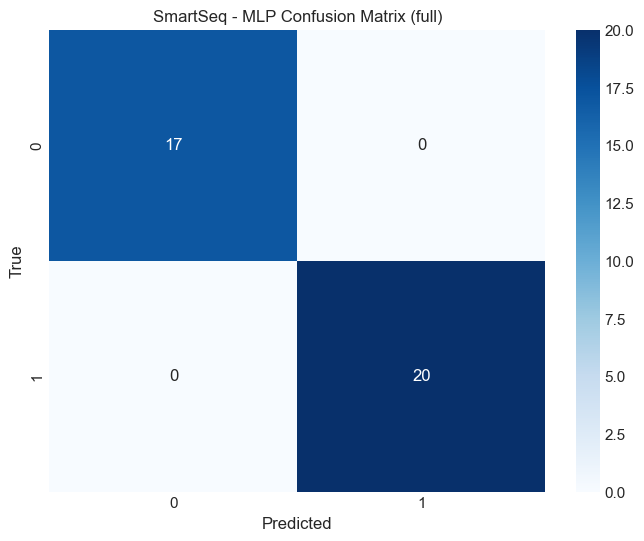

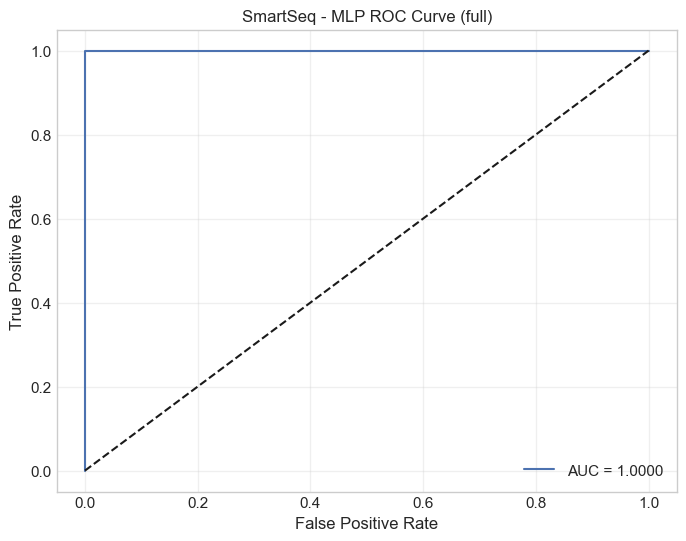

Model saved to models/SmartSeq_mlp_full.pkl
\Variant: significant
Best parameters: {'activation': 'relu', 'alpha': np.float64(0.0003771268085264386), 'batch_size': 10, 'hidden_layer_sizes': (200,), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'lbfgs'}
Best cross-validation score: 0.9794
Test accuracy: 0.9730
Test precision: 1.0000
Test recall: 0.9500
Test F1 score: 0.9744
Test AUC: 1.0000


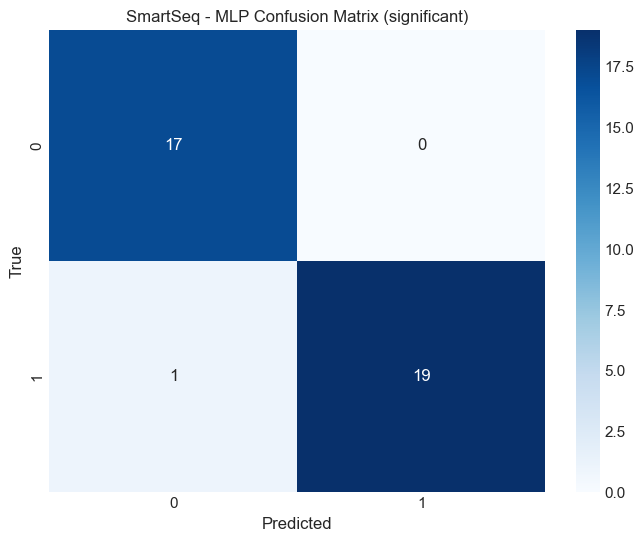

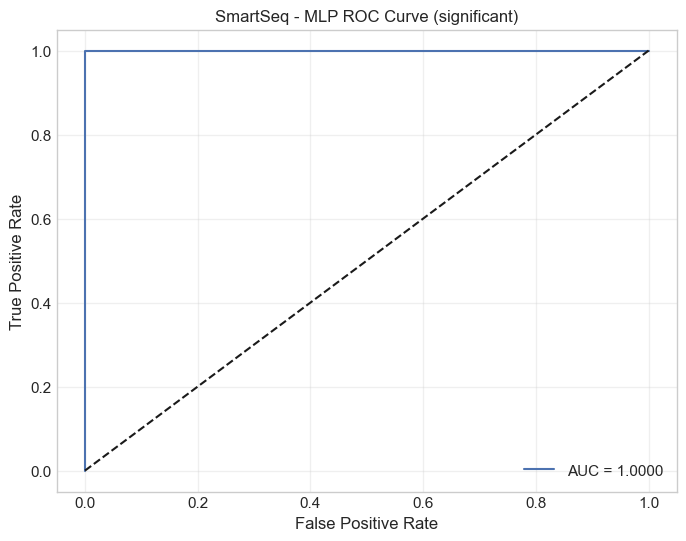

Model saved to models/SmartSeq_mlp_significant.pkl

Dataset: DropSeq
\Variant: significant
Best parameters: {'activation': 'logistic', 'alpha': np.float64(0.06680351314068701), 'batch_size': 10, 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling', 'max_iter': 500, 'solver': 'sgd'}
Best cross-validation score: 0.9328
Test accuracy: 0.9377
Test precision: 0.9424
Test recall: 0.9556
Test F1 score: 0.9490
Test AUC: 0.9851


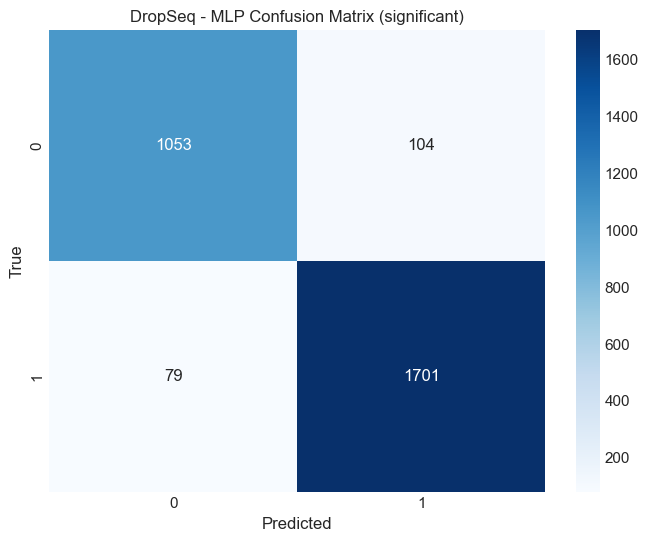

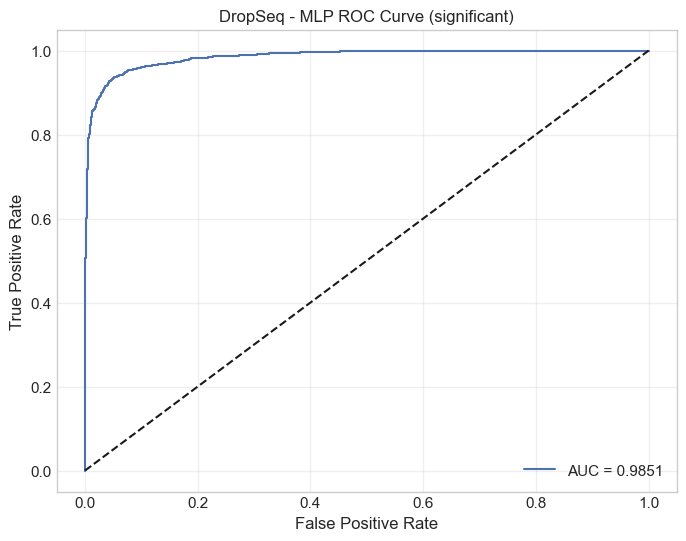

Model saved to models/DropSeq_mlp_significant.pkl


In [23]:
from scipy.stats import loguniform

def train_mlp(datasets, dataset_name):

    print(f"\nDataset: {dataset_name}")

    mlp_results = {}

    #For each dataset variant
    for variant_name, data in datasets.items():
        print(f"\Variant: {variant_name}")

        #Get training and testing data
        X_train = data['X_train']
        X_test = data['X_test']
        y_train = data['y_train']
        y_test = data['y_test']

        #define parameter distribution
        param_dist = {
            'hidden_layer_sizes': [(50,), (100,), (200,), (50, 50), (100, 100), (200, 200)],
            'activation': ['logistic', 'tanh', 'relu'],
            'solver': ['lbfgs', 'sgd', 'adam'],
            'alpha': loguniform(1e-5, 1),
            'batch_size': [10, 20, 50],
            'learning_rate': ['constant', 'invscaling', 'adaptive'],
            'max_iter': [200, 500, 1000]
            }

        #Initialize mlp classifier
        mlp_model = MLPClassifier()

        #Use GridSearchCV for hyperparameter tuning
        cv = RandomizedSearchCV(
        estimator=mlp_model,
        param_distributions=param_dist,
        cv=4,
        n_iter=25, 
        random_state=2,
        n_jobs=8)

        cv.fit(X_train, y_train)

        print(f"Best parameters: {cv.best_params_}")
        print(f"Best cross-validation score: {cv.best_score_:.4f}")

        #Get best model
        best_model = cv.best_estimator_

        #Evaluate on test set
        y_pred = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]

        #Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)

        print(f"Test accuracy: {accuracy:.4f}")
        print(f"Test precision: {precision:.4f}")
        print(f"Test recall: {recall:.4f}")
        print(f"Test F1 score: {f1:.4f}")
        print(f"Test AUC: {auc:.4f}")

        #Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"{dataset_name} - MLP Confusion Matrix ({variant_name})")
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(f"plots/{dataset_name}_knn_{variant_name}_cm.png")
        plt.show()

        #Plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f"{dataset_name} - MLP ROC Curve ({variant_name})")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(f"plots/{dataset_name}_mlp_{variant_name}_roc.png")
        plt.show()

        #Save model
        model_path = f"models/{dataset_name}_mlp_{variant_name}.pkl"
        joblib.dump(best_model, model_path)
        print(f"Model saved to {model_path}")

        #Store results
        mlp_results[variant_name] = {
            'model': best_model,
            'best_params': cv.best_params_,
            'cv_score': cv.best_score_,
            'test_accuracy': accuracy,
            'test_precision': precision,
            'test_recall': recall,
            'test_f1': f1,
            'test_auc': auc,
            'confusion_matrix': cm
        }

    return mlp_results

#Train MLP on SmartSeq 
smartseq_mlp_variants = {
    k: smartseq_supervised[k]
    for k in ['full', "significant"]
}

smartseq_mlp = train_mlp(smartseq_mlp_variants, "SmartSeq")

#Train MLP on DropSeq 
dropseq_mlp_variants = {
    k: dropseq_supervised[k]
    for k in [ "significant"]
}

dropseq_mlp = train_mlp(dropseq_mlp_variants, "DropSeq")

For SmartSeq we also tried to plot an approximate decision boundary in UMAP space, obtained by 1-NN lookup of each grid point’s nearest training sample. While the boundary appears quite rough which might suggest that the MLP is over-parameterized—those “wiggles” largely reflect UMAP’s nonlinear distortion of the data manifold and the quantization imposed by the 1-NN lookup, rather than true model overfitting.

# 10. Model Comparison

Here we plot the accuracy of each classifier


SmartSeq:

Model performance ranked by accuracy:
                model      variant  accuracy  precision  recall        f1  \
xgb_full          xgb         full  1.000000        1.0    1.00  1.000000   
xgb_significant   xgb  significant  1.000000        1.0    1.00  1.000000   
rf_significant     rf  significant  1.000000        1.0    1.00  1.000000   
rf_full            rf         full  1.000000        1.0    1.00  1.000000   
svm_significant   svm  significant  1.000000        1.0    1.00  1.000000   
svm_full          svm         full  1.000000        1.0    1.00  1.000000   
mlp_full          mlp         full  1.000000        1.0    1.00  1.000000   
knn_significant   knn  significant  0.972973        1.0    0.95  0.974359   
knn_full          knn         full  0.972973        1.0    0.95  0.974359   
mlp_significant   mlp  significant  0.972973        1.0    0.95  0.974359   

                   auc  
xgb_full         1.000  
xgb_significant  1.000  
rf_significant   1.000  
rf

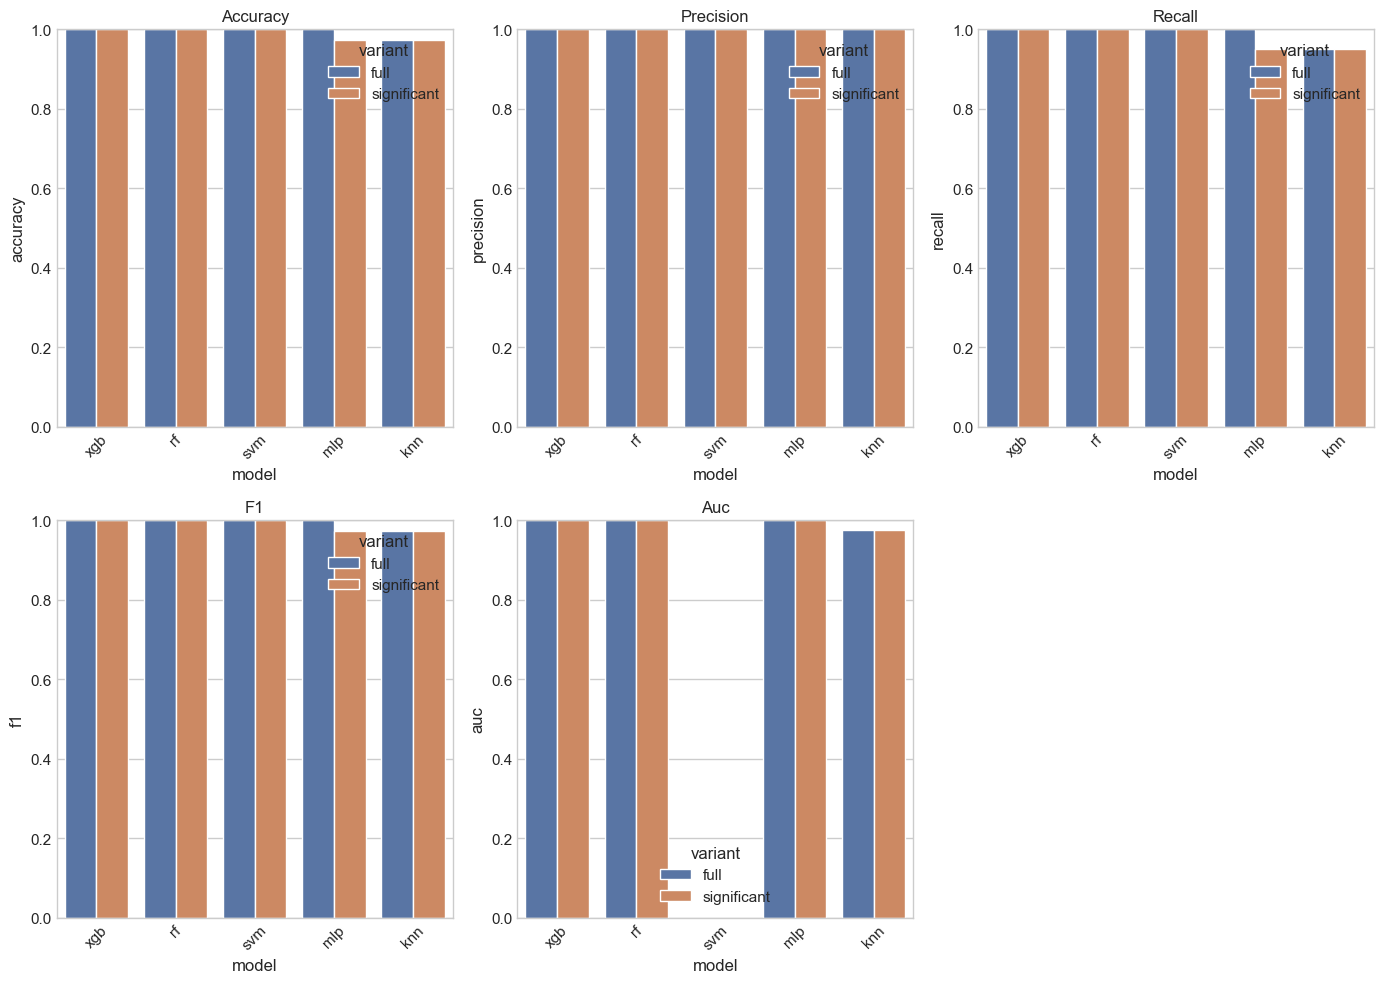

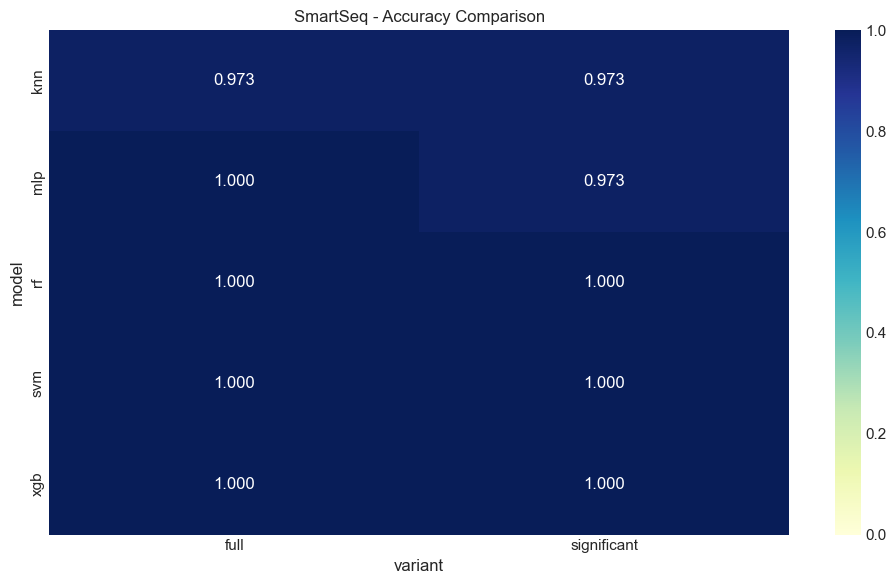

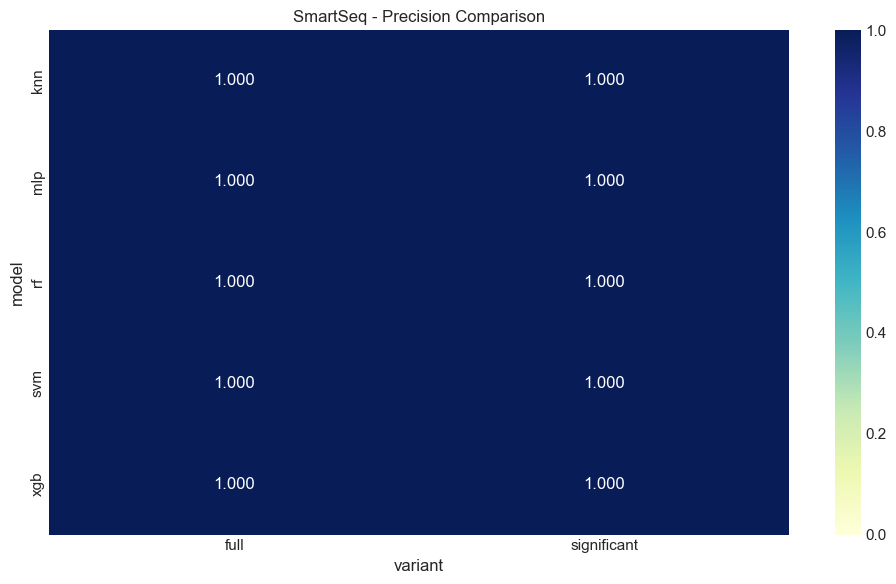

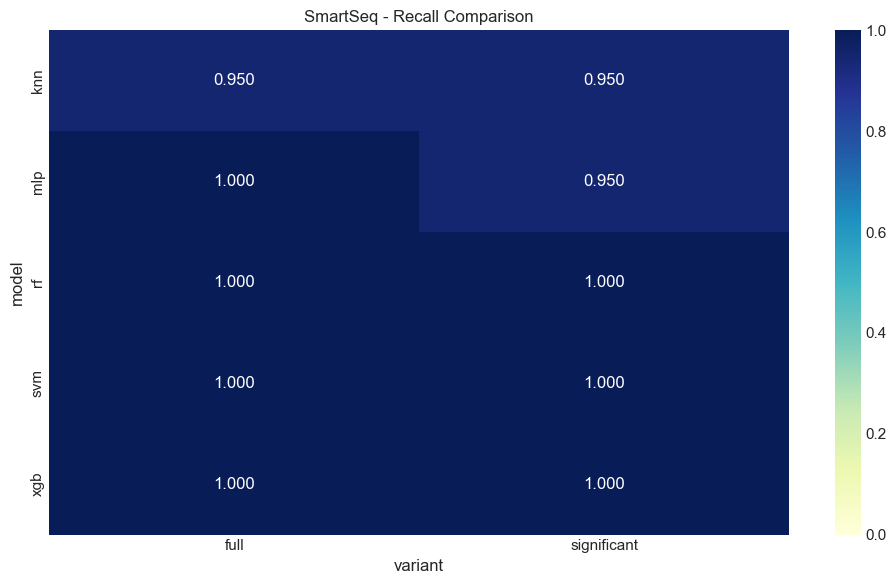

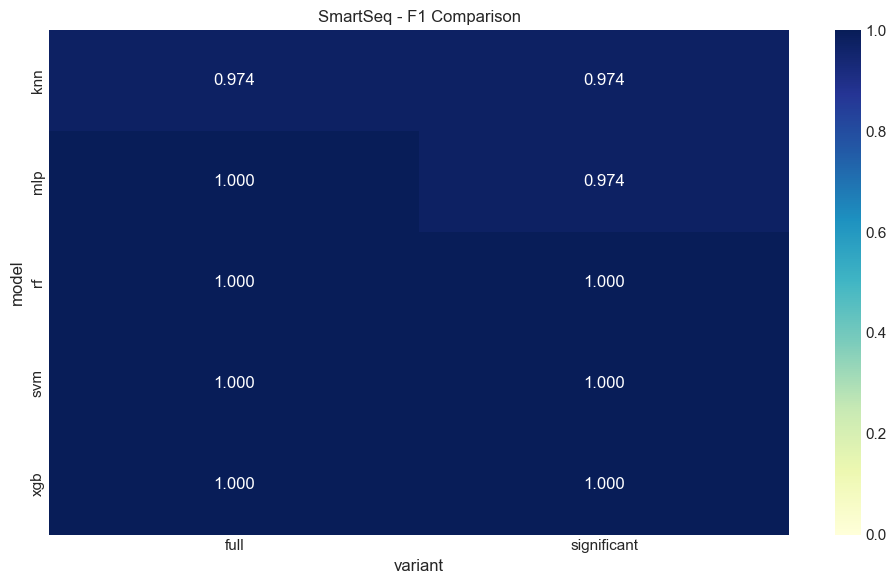

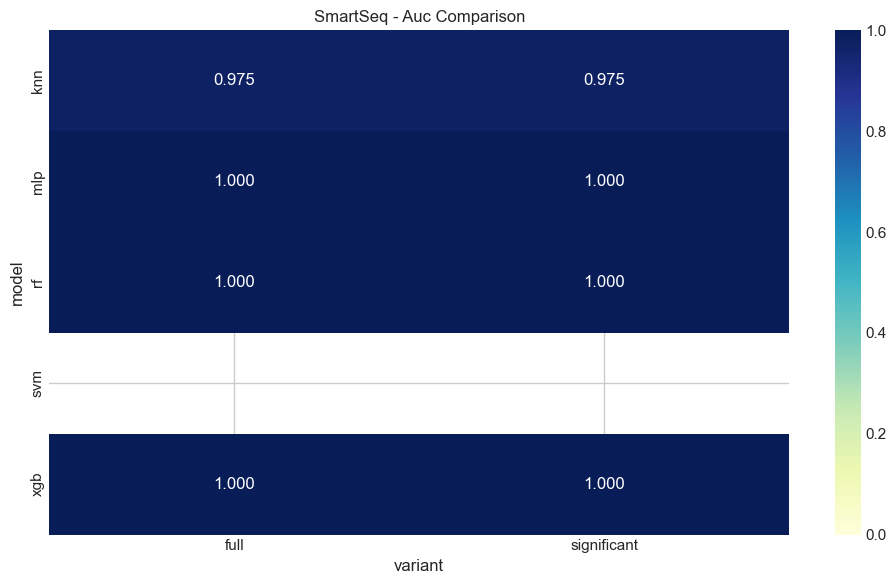


DropSeq:

Model performance ranked by accuracy:
                model      variant  accuracy  precision    recall        f1  \
xgb_significant   xgb  significant  0.952673   0.957103  0.965169  0.961119   
rf_significant     rf  significant  0.950289   0.959505  0.958427  0.958966   
mlp_significant   mlp  significant  0.937692   0.942382  0.955618  0.948954   
svm_significant   svm  significant  0.929860   0.947668  0.935955  0.941775   
knn_significant   knn  significant  0.719442   0.798750  0.717978  0.756213   

                      auc  
xgb_significant  0.990886  
rf_significant   0.988333  
mlp_significant  0.985073  
svm_significant       NaN  
knn_significant  0.728368  


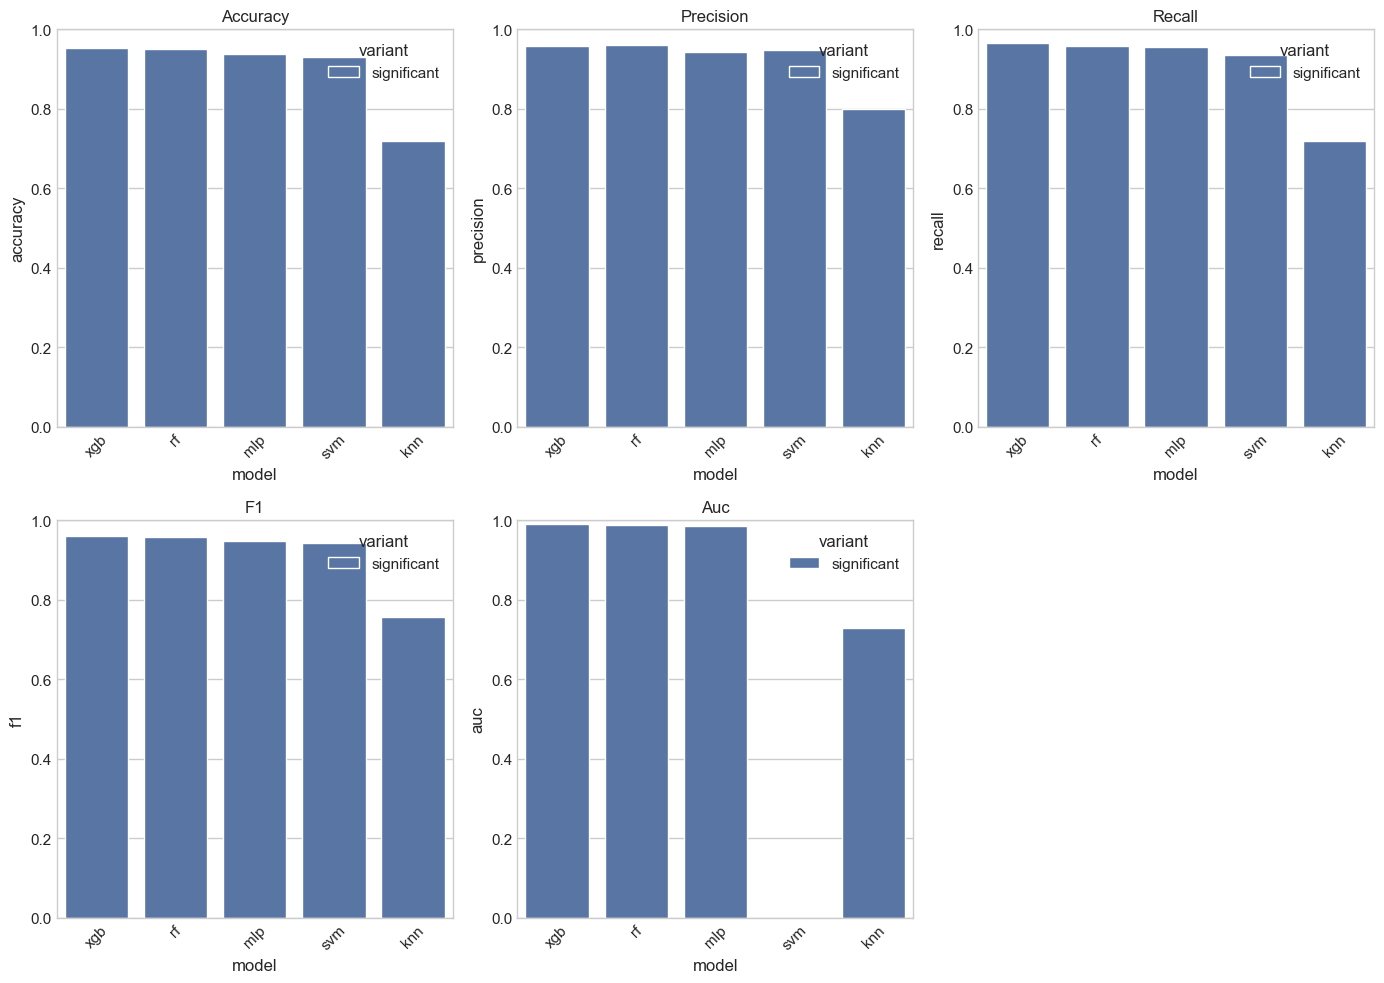

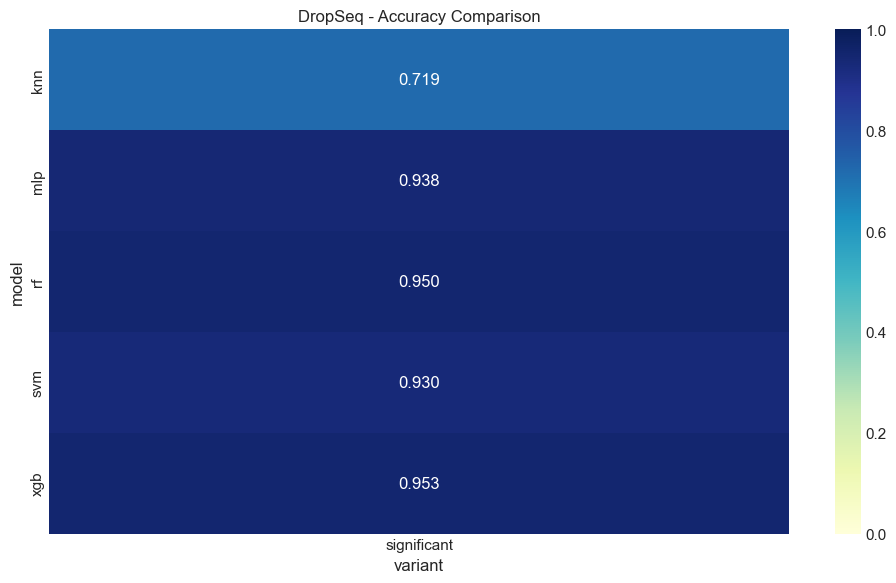

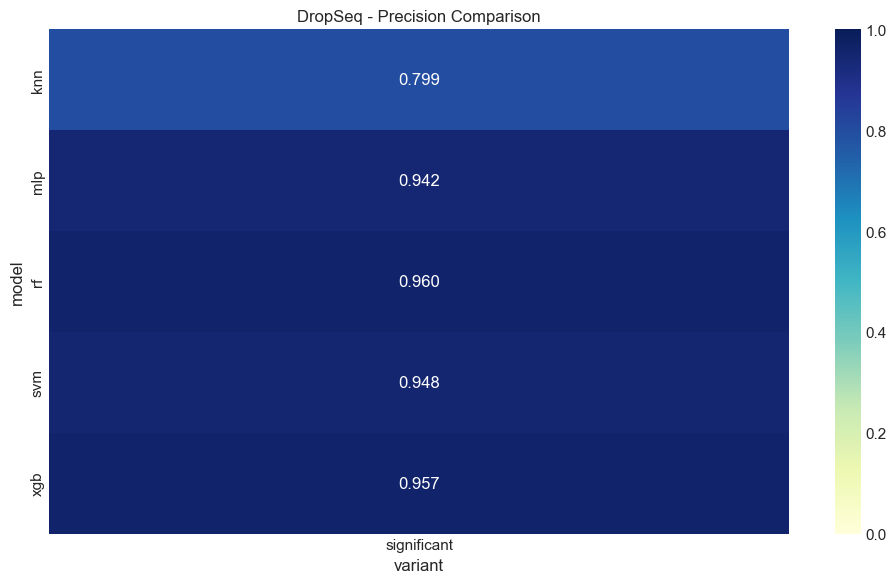

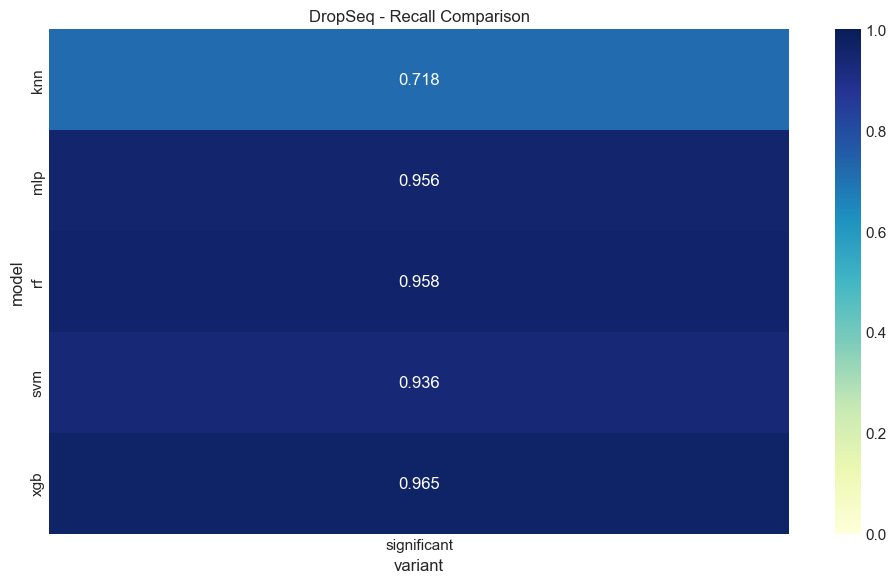

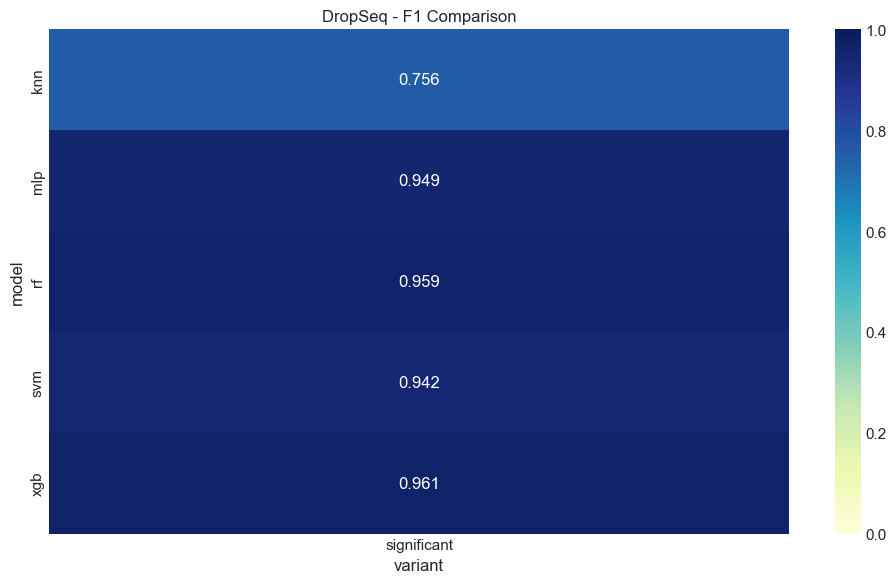

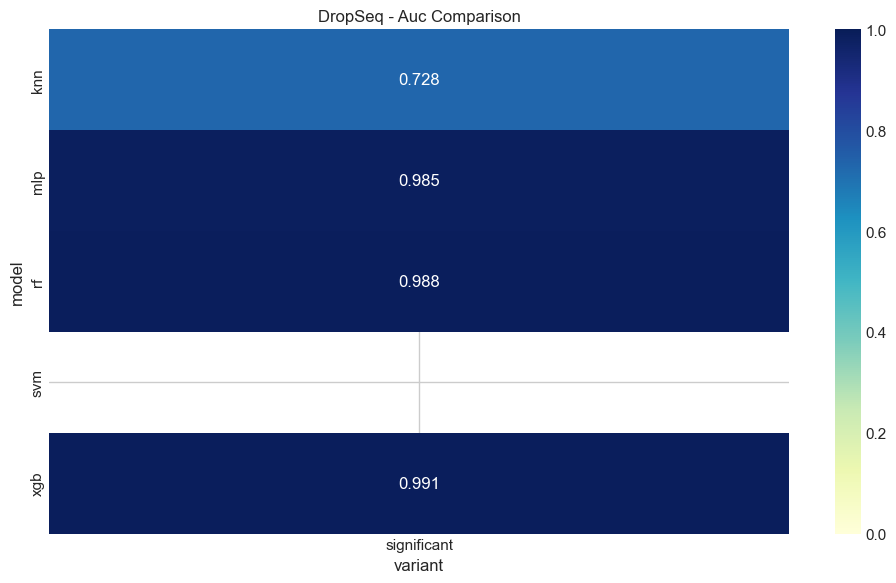

In [24]:
def compare_models(models_dict, dataset_name):

    print(f"\n{dataset_name}:")
    
    #Create a dictionary to store performance metrics for each model and dataset variant
    performance = {}
    
    #Models and their variants
    for model_name, model_results in models_dict.items():
        for variant_name, results in model_results.items():
            #Create a key for this model-variant combination
            key = f"{model_name}_{variant_name}"
            
            #Store performance metrics
            performance[key] = {
                'accuracy': results['test_accuracy'],
                'precision': results['test_precision'],
                'recall': results['test_recall'],
                'f1': results['test_f1'],
                'auc': results.get('test_auc', np.nan)  #Some models might not have AUC
            }
    
    #Convert to DataFrame for easier visualization
    perf_df = pd.DataFrame(performance).T
    
    #Add model and variant columns
    perf_df['model'] = perf_df.index.str.split('_').str[0]
    perf_df['variant'] = perf_df.index.str.split('_').str[1]
    
    #Sort by accuracy
    perf_df = perf_df.sort_values('accuracy', ascending=False)
    
    #Print the results
    print("\nModel performance ranked by accuracy:")
    print(perf_df[['model', 'variant', 'accuracy', 'precision', 'recall', 'f1', 'auc']])
    
    #Plot comparison bar charts
    plt.figure(figsize=(14, 10))
    
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        sns.barplot(x='model', y=metric, hue='variant', data=perf_df)
        plt.title(f"{metric.capitalize()}")
        plt.xticks(rotation=45)
        plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig(f"plots/{dataset_name}_model_comparison.png")
    plt.show()
    
    #Create a heatmap for comparison
    #Pivot the data to have models as rows and variants as columns
    for metric in metrics:
        pivot_df = perf_df.pivot(index='model', columns='variant', values=metric)
        
        plt.figure(figsize=(10, 6))
        sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt='.3f', vmin=0, vmax=1)
        plt.title(f"{dataset_name} - {metric.capitalize()} Comparison")
        plt.tight_layout()
        plt.savefig(f"plots/{dataset_name}_{metric}_heatmap.png")
        plt.show()
    
    return perf_df

#Combine all model results
smartseq_models = {
    'xgb': smartseq_xgb,
    'knn': smartseq_knn,
    # 'lr': smartseq_lr,
    # 'umap_lr': smartseq_lr_umap,
    'rf': smartseq_rf,
    'svm': smartseq_svm,
    'mlp': smartseq_mlp
}

dropseq_models = {
    'xgb': dropseq_xgb,
    'knn': dropseq_knn,
    # 'lr': dropseq_lr,
    # 'umap_lr': dropseq_lr_umap,
    'rf': dropseq_rf,
    'svm': dropseq_svm,
    'mlp': dropseq_mlp
}

#Compare models for SmartSeq dataset
smartseq_performance = compare_models(smartseq_models, "SmartSeq")

#Compare models for DropSeq dataset
dropseq_performance = compare_models(dropseq_models, "DropSeq")

# 11. Ensembles

We implement different voting ensembles and depending on the accuracy of which one we decide which one to use in the final prediction.

In [25]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

In this ensemble, we simply do majority voting in order to classify.

In [26]:
#Helper to extract the fitted model from  train_xxx/train_mlp results
def _get_model(result_dict, variant):
    return result_dict[variant]['model']

def implement_voting(variant, voting, weights1 = None, weights2 = None):
    estimators_smart = [
        ('xgb', _get_model(smartseq_xgb,variant)),
        ('knn', _get_model(smartseq_knn,variant)),
        # ('lr',  _get_model(smartseq_lr,variant)),
        ('rf',  _get_model(smartseq_rf,variant)),
        ('svm', _get_model(smartseq_svm,variant)),
        ('mlp', _get_model(smartseq_mlp,variant))
    ]
    voting_clf_smart = VotingClassifier(estimators=estimators_smart, voting=voting, weights=weights1)

    estimators_drop = [
        ('xgb', _get_model(dropseq_xgb,variant)),
        ('knn', _get_model(dropseq_knn,variant)),
        # ('lr',  _get_model(dropseq_lr,variant)),
        ('rf',  _get_model(dropseq_rf,variant)),
        ('svm', _get_model(dropseq_svm,variant)),
        ('mlp', _get_model(dropseq_mlp,variant))
    ]
    voting_clf_drop = VotingClassifier(estimators=estimators_drop, voting=voting, weights=weights2)

    #Train and Evaluate on SmartSeq 
    print(f"\nSMARTSEQ {voting} VOTING:")
    X_train_s, y_train_s = smartseq_supervised[variant]['X_train'], smartseq_supervised[variant]['y_train']
    X_test_s,  y_test_s  = smartseq_supervised[variant]['X_test'],  smartseq_supervised[variant]['y_test']

    voting_clf_smart.fit(X_train_s, y_train_s)
    y_pred_s = voting_clf_smart.predict(X_test_s)

    acc_s = accuracy_score(y_test_s, y_pred_s)
    print(f"Accuracy: {acc_s:.4f}")
    print(classification_report(y_test_s, y_pred_s))

    cm_s = confusion_matrix(y_test_s, y_pred_s)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_s, annot=True, fmt='d', cmap='Blues',
                xticklabels=voting_clf_smart.classes_,
                yticklabels=voting_clf_smart.classes_)
    plt.title(f"SmartSeq {voting} Voting\nConfusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

    #Train & Evaluate on DropSeq 
    print(f"\nDROPSEQ {voting} VOTING:")
    X_train_d, y_train_d = dropseq_supervised[variant]['X_train'], dropseq_supervised[variant]['y_train']
    X_test_d,  y_test_d  = dropseq_supervised[variant]['X_test'],  dropseq_supervised[variant]['y_test']

    voting_clf_drop.fit(X_train_d, y_train_d)
    y_pred_d = voting_clf_drop.predict(X_test_d)

    acc_d = accuracy_score(y_test_d, y_pred_d)
    print(f"Accuracy: {acc_d:.4f}")
    print(classification_report(y_test_d, y_pred_d))

    cm_d = confusion_matrix(y_test_d, y_pred_d)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_d, annot=True, fmt='d', cmap='Greens',
                xticklabels=voting_clf_drop.classes_,
                yticklabels=voting_clf_drop.classes_)
    plt.title(f"DropSeq {voting} Voting\nConfusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


SMARTSEQ hard VOTING:
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        20

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



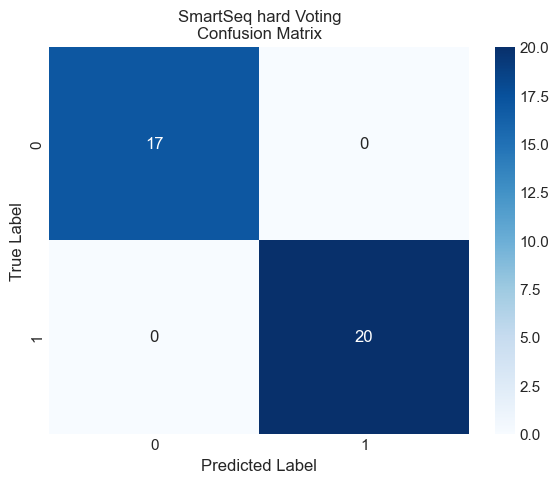


DROPSEQ hard VOTING:
Accuracy: 0.9523
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1157
           1       0.96      0.96      0.96      1780

    accuracy                           0.95      2937
   macro avg       0.95      0.95      0.95      2937
weighted avg       0.95      0.95      0.95      2937



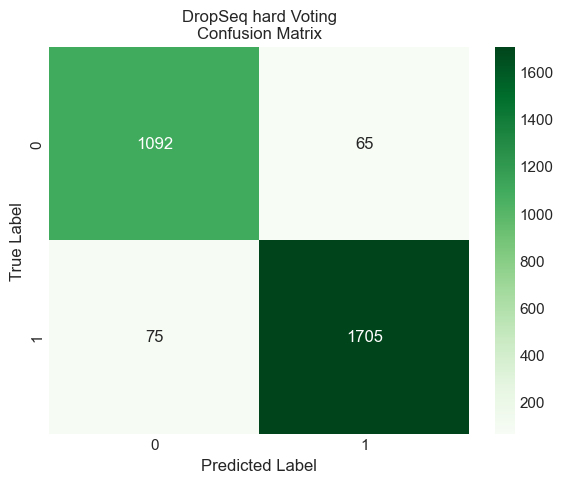

In [27]:
implement_voting("significant", "hard")

Now, we retrive the accuracies on each algorithm.

Smartseq weights[10, 9, 10, 10, 9]
Dropseq weights[9, 7, 9, 9, 9]

SMARTSEQ hard VOTING:
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        20

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



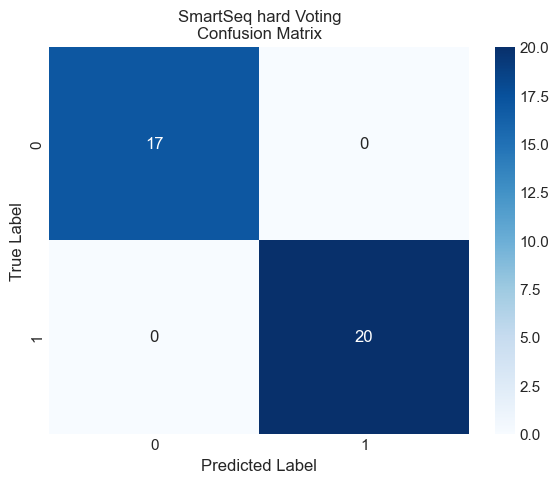


DROPSEQ hard VOTING:
Accuracy: 0.9540
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1157
           1       0.96      0.96      0.96      1780

    accuracy                           0.95      2937
   macro avg       0.95      0.95      0.95      2937
weighted avg       0.95      0.95      0.95      2937



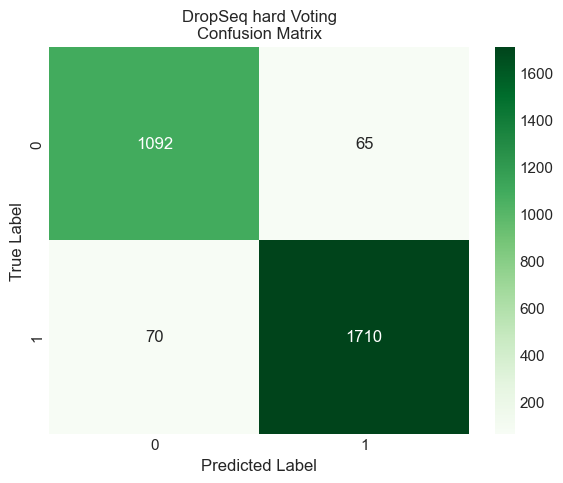

In [28]:
def retrieve_accuracies_smartseq(variant):
    #Define models as a list of (name, model) tuples
    models = [
        ('smartseq_xgb', smartseq_xgb),
        ('smartseq_knn', smartseq_knn),
        # ('smartseq_lr', _get_model(smartseq_lr, variant)),
        ('smartseq_rf', smartseq_rf),
        ('smartseq_svm', smartseq_svm),
        ('smartseq_mlp', smartseq_mlp),
    ]

    accuracies = {}
    for name, model in models:
        accuracies[name] = model[variant]['test_accuracy']
    
    return accuracies

def retrieve_accuracies_dropseq(variant):
    #Define models as a list of (name, model) tuples
    models = [
        ('dropseq_xgb', dropseq_xgb),
        ('dropseq_knn', dropseq_knn),
        # ('dropseq_lr', _get_model(dropseq_lr, variant)),
        ('dropseq_rf', dropseq_rf),
        ('dropseq_svm', dropseq_svm),
        ('dropseq_mlp', dropseq_mlp)
    ]

    accuracies = {}
    for name, model in models:
        accuracies[name] = model[variant]['test_accuracy']
    
    return accuracies

accuracies1 = retrieve_accuracies_smartseq("significant")
accuracies2 = retrieve_accuracies_dropseq("significant")
weights1 = []
weights2 = []

for i, k in accuracies1.items():
    weights1.append(int((k) * 10))
for i, k in accuracies2.items():
    weights2.append(int((k ) * 10))

print(f"Smartseq weights{weights1}")
print(f"Dropseq weights{weights2}")

implement_voting("significant", "hard", weights1 = weights1, weights2 = weights2)

Based on the accuracies retrieved above, now we weigh each algorithm based on the accuracies that we obtained.

In [29]:
def implement_voting_cv(variant, voting, weights1 = None, weights2 = None, cv_folds=5):
    estimators_smart = [
        ('xgb', _get_model(smartseq_xgb,variant)),
        ('knn', _get_model(smartseq_knn,variant)),
        # ('lr',  _get_model(smartseq_lr,variant)),
        ('rf',  _get_model(smartseq_rf,variant)),
        ('svm', _get_model(smartseq_svm,variant)),
        ('mlp', _get_model(smartseq_mlp,variant))
    ]
    voting_clf_smart = VotingClassifier(estimators=estimators_smart, voting=voting, weights=weights1)

    estimators_drop = [
        ('xgb', _get_model(dropseq_xgb,variant)),
        ('knn', _get_model(dropseq_knn,variant)),
        # ('lr',  _get_model(dropseq_lr,variant)),
        ('rf',  _get_model(dropseq_rf,variant)),
        ('svm', _get_model(dropseq_svm,variant)),
        ('mlp', _get_model(dropseq_mlp,variant))
    ]
    voting_clf_drop = VotingClassifier(estimators=estimators_drop, voting=voting, weights=weights2)

    #Combine train and test sets for full dataset CV
    X_s = np.vstack((smartseq_supervised[variant]['X_train'], smartseq_supervised[variant]['X_test']))
    y_s = np.hstack((smartseq_supervised[variant]['y_train'], smartseq_supervised[variant]['y_test']))

    X_d = np.vstack((dropseq_supervised[variant]['X_train'], dropseq_supervised[variant]['X_test']))
    y_d = np.hstack((dropseq_supervised[variant]['y_train'], dropseq_supervised[variant]['y_test']))

    #Cross-validation on SmartSeq
    print(f"\nSMARTSEQ {voting} VOTING - {cv_folds}-Fold CV")
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=2)
    scores_s = cross_val_score(voting_clf_smart, X_s, y_s, cv=cv, scoring='accuracy')
    print(f"Accuracy scores: {scores_s}")
    print(f"Mean Accuracy: {scores_s.mean():.4f} (+/- {scores_s.std():.4f})")
    print(f"Number of misclassified samples: {int(1-scores_s.mean())*(X_s.shape[0])}")
    
    #Cross-validation on DropSeq
    print(f"\nDROPSEQ {voting} VOTING - {cv_folds}-Fold CV")
    scores_d = cross_val_score(voting_clf_drop, X_d, y_d, cv=cv, scoring='accuracy')
    print(f"Accuracy scores: {scores_d}")
    print(f"Mean Accuracy: {scores_d.mean():.4f} (+/- {scores_d.std():.4f})")

    if weights1 != None:
        #Save model
        model_path = f"models/SmartSeq_weight_voting_{variant}.pkl"
        joblib.dump(voting_clf_smart, model_path)
        print(f"Model saved to {model_path}")

        #Save model
        model_path = f"models/DropSeq_weight_voting_{variant}.pkl"
        joblib.dump(voting_clf_drop, model_path)
        print(f"Model saved to {model_path}")

Here we do normal majority vote hard voting for comparison

In [30]:
implement_voting_cv("significant", "hard")


SMARTSEQ hard VOTING - 5-Fold CV
Accuracy scores: [1.         1.         1.         0.94444444 0.97222222]
Mean Accuracy: 0.9833 (+/- 0.0222)
Number of misclassified samples: 0

DROPSEQ hard VOTING - 5-Fold CV
Accuracy scores: [0.96186585 0.95778005 0.95299728 0.95810627 0.95231608]
Mean Accuracy: 0.9566 (+/- 0.0035)


Here we run the weighted classifier

In [31]:
implement_voting_cv("significant", "hard", weights1 = weights1, weights2 = weights2)


SMARTSEQ hard VOTING - 5-Fold CV
Accuracy scores: [1.         0.97297297 1.         0.94444444 0.97222222]
Mean Accuracy: 0.9779 (+/- 0.0207)
Number of misclassified samples: 0

DROPSEQ hard VOTING - 5-Fold CV
Accuracy scores: [0.96152537 0.95539666 0.95299728 0.96014986 0.95333787]
Mean Accuracy: 0.9567 (+/- 0.0035)
Model saved to models/SmartSeq_weight_voting_significant.pkl
Model saved to models/DropSeq_weight_voting_significant.pkl


# 12. Stacking Classifier

Instead a generalisation of voting is given by stacking classifier, which is much more robust, is stacking, which trains an additional classifier based on the labels predicted by the other classifiers

In [32]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

def implement_stacking_cv(variant, cv_folds=5):
    #Define base estimators for SMARTSEQ
    estimators_smart = [
        ('xgb', _get_model(smartseq_xgb, variant)),
        ('knn', _get_model(smartseq_knn, variant)),
        ('rf',  _get_model(smartseq_rf, variant)),
        ('svm', _get_model(smartseq_svm, variant)),
        ('mlp', _get_model(smartseq_mlp, variant))
    ]

    #Define base estimators for DROPSEQ
    estimators_drop = [
        ('xgb', _get_model(dropseq_xgb, variant)),
        ('knn', _get_model(dropseq_knn, variant)),
        ('rf',  _get_model(dropseq_rf, variant)),
        ('svm', _get_model(dropseq_svm, variant)),
        ('mlp', _get_model(dropseq_mlp, variant))
    ]

    #Meta-model
    final_estimator = LogisticRegression(max_iter=1000)

    #Create StackingClassifier for each dataset
    stacking_clf_smart = StackingClassifier(
        estimators=estimators_smart,
        final_estimator=final_estimator,
        cv=cv_folds,
        passthrough=False,
        n_jobs=8
    )

    stacking_clf_drop = StackingClassifier(
        estimators=estimators_drop,
        final_estimator=final_estimator,
        cv=cv_folds,
        passthrough=False,
        n_jobs=8
    )

    #Merge train and test sets
    X_s = np.vstack((smartseq_supervised[variant]['X_train'], smartseq_supervised[variant]['X_test']))
    y_s = np.hstack((smartseq_supervised[variant]['y_train'], smartseq_supervised[variant]['y_test']))

    X_d = np.vstack((dropseq_supervised[variant]['X_train'], dropseq_supervised[variant]['X_test']))
    y_d = np.hstack((dropseq_supervised[variant]['y_train'], dropseq_supervised[variant]['y_test']))

    #Cross-validation
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=1)

    print(f"\nSMARTSEQ STACKING - {cv_folds}-Fold CV")
    scores_s = cross_val_score(stacking_clf_smart, X_s, y_s, cv=cv, scoring='accuracy')
    print(f"Accuracy scores: {scores_s}")
    print(f"Mean Accuracy: {scores_s.mean():.4f} (+/- {scores_s.std():.4f})")

    print(f"\nDROPSEQ STACKING - {cv_folds}-Fold CV")
    scores_d = cross_val_score(stacking_clf_drop, X_d, y_d, cv=cv, scoring='accuracy')
    print(f"Accuracy scores: {scores_d}")
    print(f"Mean Accuracy: {scores_d.mean():.4f} (+/- {scores_d.std():.4f})")

    #Fit final model on full dataset
    stacking_clf_smart.fit(X_s, y_s)
    stacking_clf_drop.fit(X_d, y_d)

    print("\nFinal stacking models trained on full SmartSeq and DropSeq datasets.")

    return stacking_clf_smart, stacking_clf_drop

In [33]:
stacking_clf_smart, stacking_clf_drop = implement_stacking_cv("significant")


SMARTSEQ STACKING - 5-Fold CV
Accuracy scores: [1.         0.97297297 0.97222222 1.         0.97222222]
Mean Accuracy: 0.9835 (+/- 0.0135)

DROPSEQ STACKING - 5-Fold CV
Accuracy scores: [0.96254682 0.96220633 0.96117166 0.96525886 0.95197548]
Mean Accuracy: 0.9606 (+/- 0.0045)

Final stacking models trained on full SmartSeq and DropSeq datasets.


In [34]:
#Save model
model_path = f"models/SmartSeq_stacking_clas_significant.pkl"
joblib.dump(stacking_clf_smart, model_path)
print(f"Model saved to {model_path}")

#Save model
model_path = f"models/DropSeq_stacking_clas_significant.pkl"
joblib.dump(stacking_clf_drop, model_path)
print(f"Model saved to {model_path}")

Model saved to models/SmartSeq_stacking_clas_significant.pkl
Model saved to models/DropSeq_stacking_clas_significant.pkl


# 13. Predictions on anonim datasets

## Data loading 

In [35]:
#Load SmartSeq data
df_predictions_path = f'SmartSeq/{tumor}_SmartS_Filtered_Normalised_3000_Data_test_anonim.txt'
df_smartseq_predictions = pd.read_csv(df_predictions_path, delimiter=' ')
print(f"SmartSeq data shape before transposition: {df_smartseq_predictions.shape}")

SmartSeq data shape before transposition: (3000, 45)


In [36]:
#Load DropSeq data
df_predictions_path = f'DropSeq/{tumor}_Filtered_Normalised_3000_Data_test_anonim.txt'
df_dropseq_predictions = pd.read_csv(df_predictions_path, delimiter=' ')
print(f"DropSeq data shape before transposition: {df_dropseq_predictions.shape}")

DropSeq data shape before transposition: (3000, 3671)


In [37]:
#Transpose data (to have genes as features and cells as rows)
df_dropseq_predictionsT = df_dropseq_predictions.T
df_smartseq_predictionsT = df_smartseq_predictions.T

In [38]:
print(f"\nSmartSeq data shape after transposition: {df_smartseq_predictionsT.shape}")
print(f"DropSeq data shape after transposition: { df_dropseq_predictionsT.shape}")


SmartSeq data shape after transposition: (45, 3000)
DropSeq data shape after transposition: (3671, 3000)


In [39]:
df_smartseq_predictionsT.head()

,DDIT4,ANGPTL4,CALML5,KRT14,CCNB1,IGFBP3,AKR1C2,KRT6A,NDRG1,KRT4,...,MST1R,ZYG11A,NRG1,RBMS3,VCPIP1,LINC02693,OR8B9P,NEAT1,ZDHHC23,ODAD2
1,0,0,0,169,233,227,521,577,0,0,...,0,0,176,0,0,48,0,118,6,0
2,2475,0,0,0,3537,843,214,0,3,0,...,106,0,333,0,18,65,0,39,0,0
3,9088,2143,0,0,124,0,0,0,415,0,...,299,0,0,45,0,0,0,172,0,0
4,6909,3086,0,909,78,466,508,193,453,0,...,319,0,95,167,0,5,0,31,0,10
5,13655,2196,0,1,1,14688,3872,184,884,176,...,0,0,1,0,0,0,0,224,0,0


In [40]:
df_dropseq_predictionsT.head()

,H1-5,MALAT1,MT-RNR2,ARVCF,BCYRN1,ATXN7L2,IGFBP3,H1-3,CTIF,RNF123,...,BATF3,CDKN3,DLD,PMPCA,ZNF165,SCCPDH,NTAN1,CLIP2,DUSP23,ZNF682
1,0,3,1,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## DATASET VISUALISATION

In [41]:
smartseq_data_pred = df_smartseq_predictionsT.copy()
dropseq_data_pred = df_dropseq_predictionsT.copy()

smartseq_pred_selected = smartseq_data_pred[smartseq_features["significant"]]
dropseq_pred_selected = dropseq_data_pred[dropseq_features["significant"]]

In [42]:
smartseq_pred_norm = StandardScaler().fit_transform(smartseq_pred_selected)
dropseq_pred_norm = StandardScaler().fit_transform(dropseq_pred_selected)

labels_smartseq = stacking_clf_smart.predict(smartseq_pred_norm)
labels_dropseq = stacking_clf_drop.predict(dropseq_pred_norm)

In [50]:
import csv
def save_labels(labels, data):
    with open(f'{data}_labels.tsv', 'w', newline='') as file:
        writer = csv.writer(file, delimiter='\t')
        for label in labels:
            writer.writerow([label])

save_labels(labels_smartseq, "smart")
save_labels(labels_dropseq, "drop")

(array([23.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 22.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

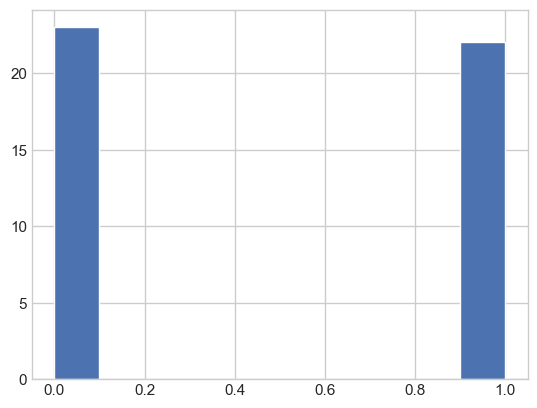

In [43]:
plt.hist(labels_smartseq)

(array([1487.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2184.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

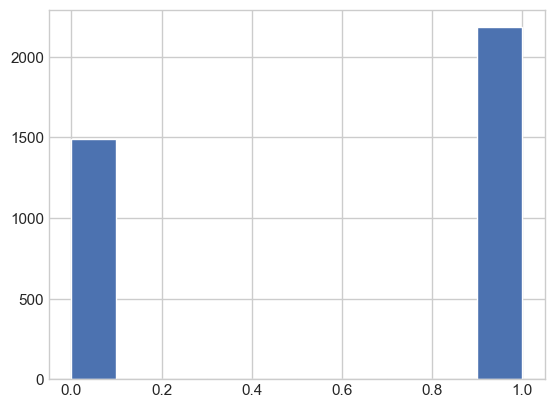

In [44]:
plt.hist(labels_dropseq)

In [45]:
print("Computing UMAP 2D...")
umap_2d_s = umap.UMAP(
    n_neighbors=10,
    min_dist=0.67,
    n_components=2,
    metric = "cosine",
    random_state=1
)
# umap_embedding_2d_s = umap_2d_s.fit_transform(smartseq_data_pred)
umap_embedding_2d_s = PCA(n_components=3).fit_transform(smartseq_pred_norm)

Computing UMAP 2D...


In [46]:
print("Computing UMAP 2D...")
umap_2d_d = umap.UMAP(
    n_neighbors=11,
    min_dist=0.204,
    n_components=2,
    metric = "correlation",
    random_state=23
)
# umap_embedding_2d_d = umap_2d_d.fit_transform(dropseq_data_pred)
umap_embedding_2d_d = PCA(n_components=3).fit_transform(dropseq_pred_norm)

Computing UMAP 2D...


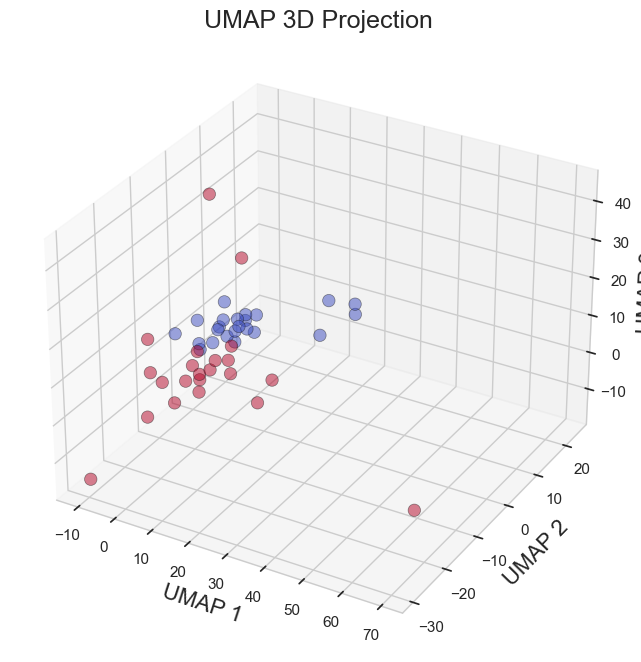

In [47]:
from mpl_toolkits.mplot3d import Axes3D  #Needed for 3D plots

#Create a 3D figure
fig = plt.figure(figsize=(24, 8))
ax = fig.add_subplot(111, projection='3d')

#Plot the 3D scatter
sc = ax.scatter(
    umap_embedding_2d_s[:, 0],
    umap_embedding_2d_s[:, 1],
    umap_embedding_2d_s[:, 2],
    s=80,
    alpha=0.5,
    c=labels_smartseq,
    cmap='coolwarm',
    edgecolor='k',
    linewidth=0.5
)

#Set axis labels
ax.set_xlabel("UMAP 1", fontsize=16)
ax.set_ylabel("UMAP 2", fontsize=16)
ax.set_zlabel("UMAP 3", fontsize=16)
ax.set_title("UMAP 3D Projection", fontsize=18)

# plt.legend(handles=legend_elements, loc='best', fontsize=14)

plt.show()

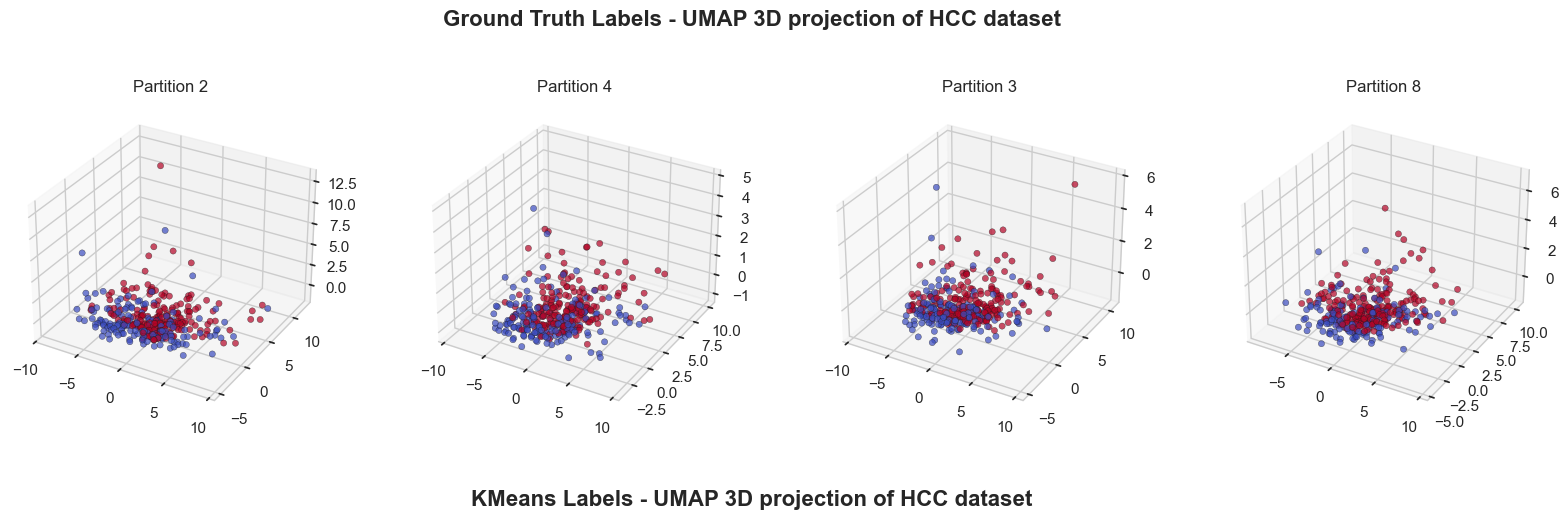

In [48]:
import random
import matplotlib.gridspec as gridspec

random.seed(32)

splits = 10
selected_indices = random.sample(range(splits), 4)
indices = np.arange(dropseq_data_pred.shape[0])
np.random.shuffle(indices)
partitions = np.array_split(indices, splits)

#Create figure and gridspec with space between rows
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, len(selected_indices), height_ratios=[1, 1], hspace=0.4)

#Add title ABOVE the first row
fig.text(0.5, 0.96, 'Ground Truth Labels - UMAP 3D projection of HCC dataset',
         ha='center', va='center', fontsize=16, fontweight='bold')

#Add title BELOW the first row (above second row)
fig.text(0.5, 0.48, 'KMeans Labels - UMAP 3D projection of HCC dataset',
         ha='center', va='center', fontsize=16, fontweight='bold')

#Plot first row (ground truth labels)
for j, idx in enumerate(selected_indices):
    ax = fig.add_subplot(gs[0, j], projection='3d')
    part = np.array(partitions[idx], dtype=int)
    scatter = ax.scatter(umap_embedding_2d_d[part, 0],
                         umap_embedding_2d_d[part, 1],
                         umap_embedding_2d_d[part, 2],
                         c=np.array(labels_dropseq)[part],
                         cmap='coolwarm', alpha=0.7, edgecolor='k', linewidth=0.3, s=20)
    ax.set_title(f'Partition {idx+1}')